In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pickle
import yaml
import pandas as pd
import os
import getdist
from getdist import plots, MCSamples
import sacc
import pacc
import random
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams.update({'font.size': 22})
plt.rc('legend',fontsize=18)
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.10.0


## Load Data

In [2]:
s_gcgc = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y_gcgc = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc.yml"), Loader=yaml.FullLoader)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/sacc/sacc.py:936: UserWarning: The FITS format without the 'sacc_ordering' column is deprecated. Assuming data rows are in the correct order as it was before version 1.0.
  warnings.warn(


In [3]:
cle_gcgc  = pacc.ClsEnsemble(s_gcgc, y_gcgc,   label="CosmoDC2 3x2  - data")

In [4]:
tpts = np.load("covs/COSMODC2/bpz_gcgc_tpts_covs.npz")
cov = np.diag(tpts["cov"])
tt_dz   = np.diag(tpts["TT_dz"])   - cov
tt_wzdz = np.diag(tpts["TT_wzdz"]) - cov
tt_pca  = np.diag(tpts["TT_pca"])  - cov
tt_gp   = np.diag(tpts["TT_gp"])   - cov
total_l = 0
_tt_dz = []
_tt_wzdz = []
_tt_pca = []
_tt_gp = []
_cov = []
for d in cle_gcgc.data:
    dz = tt_dz[total_l:total_l+len(d)]
    wzdz = tt_wzdz[total_l:total_l+len(d)]
    pca = tt_pca[total_l:total_l+len(d)]
    gp = tt_gp[total_l:total_l+len(d)]
    c = cov[total_l:total_l+len(d)]
    _tt_dz.append(dz/c)
    _tt_wzdz.append(wzdz/c)
    _tt_pca.append(pca/c)
    _tt_gp.append(gp/c)
    _cov.append(c)
    total_l += len(d)

cle_gcgc_tt_dz = pacc.ClsEnsemble(s_gcgc, y_gcgc, label=r"$\delta z$")
cle_gcgc_tt_dz.errs = _tt_dz
cle_gcgc_tt_wzdz = pacc.ClsEnsemble(s_gcgc, y_gcgc, label=r"$w_z \, \delta z$")
cle_gcgc_tt_wzdz.errs = _tt_wzdz
cle_gcgc_tt_pca = pacc.ClsEnsemble(s_gcgc, y_gcgc, label="PCA")
cle_gcgc_tt_pca.errs = _tt_pca
cle_gcgc_tt_gp = pacc.ClsEnsemble(s_gcgc, y_gcgc, label="GP")
cle_gcgc_tt_gp.errs = _tt_gp

In [5]:
labels = [
    r'$\left(\frac{\partial t^{\rm lens \, 1} \partial t^{\rm lens \, 1}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm lens \, 2} \partial t^{\rm lens \, 2}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm lens \, 3} \partial t^{\rm lens \, 3}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm lens \, 4} \partial t^{\rm lens \, 4}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm lens \, 5} \partial t^{\rm lens \, 5}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm source \, 1} \partial t^{\rm source \, 1}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm source \, 2} \partial t^{\rm source \, 2}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm source \, 3} \partial t^{\rm source \, 3}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm source \, 4} \partial t^{\rm source \, 4}}{\partial_\theta^2}\right)/ \mathbb{C}$',
    r'$\left(\frac{\partial t^{\rm source \, 5} \partial t^{\rm source \, 5}}{\partial_\theta^2}\right)/ \mathbb{C}$',
]

In [6]:
#colors = ['r', 'b', 'g', 'orange']
#g = pacc.plot_errs([[cle_gcgc_tt_dz, cle_gcgc_tt_wzdz, cle_gcgc_tt_pca, cle_gcgc_tt_gp]], cle_gcgc.pairs,
#               configs=[{'colors': colors},
#                        {'colors': colors}, 
#                        {'colors': colors}, 
#                        {'colors': colors}],
#                labels=labels);
#g.savefig("./paper_plots/tpts_3x2.pdf", bbox_inches='tight')

In [7]:
labels = [
    r'$C_\ell^{\rm lens 1 \, lens 1}$',
    r'$C_\ell^{\rm lens 2 \, lens 2}$',
    r'$C_\ell^{\rm lens 3 \, lens 3}$',
    r'$C_\ell^{\rm lens 4 \, lens 4}$',
    r'$C_\ell^{\rm lens 5 \, lens 5}$',
]

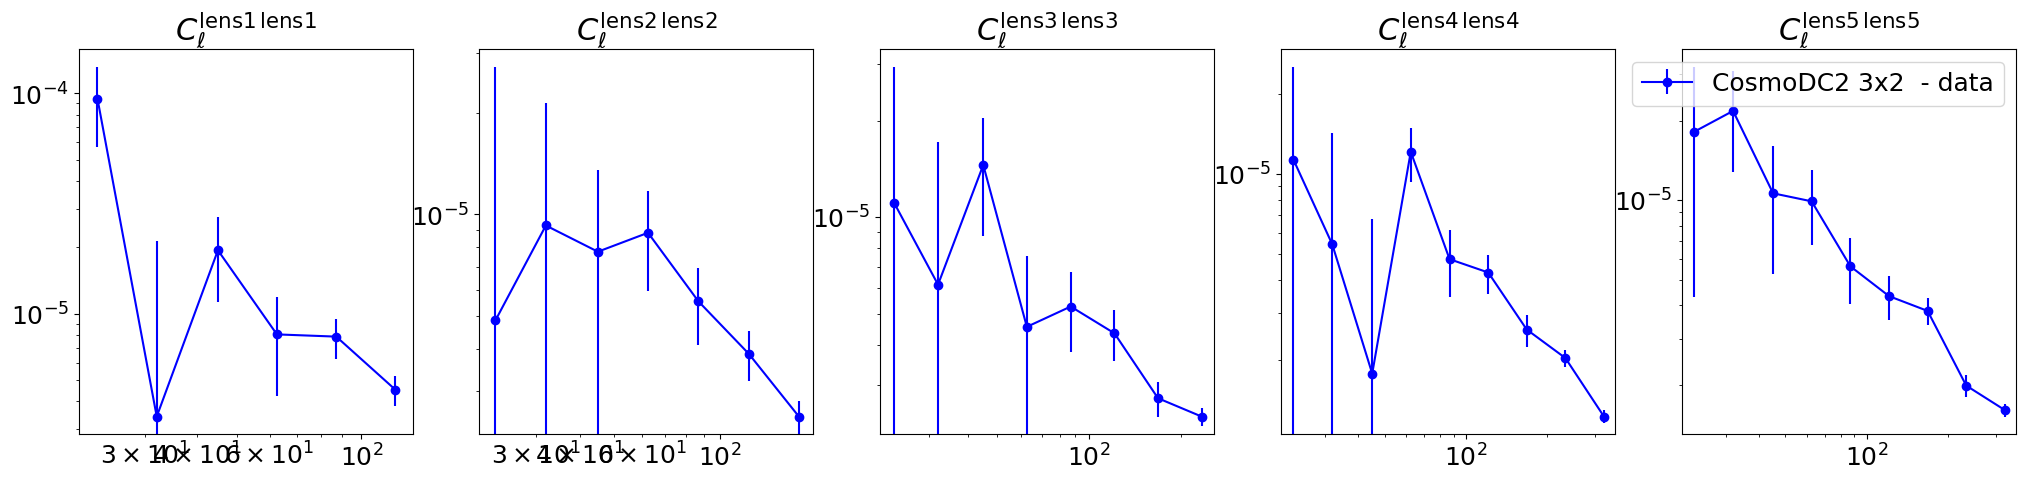

In [8]:
g = pacc.plot_cls([[cle_gcgc]], cle_gcgc.pairs, labels=labels);
g.savefig("./paper_plots/data_3x2.pdf", bbox_inches='tight')

## Load Chains

In [9]:
def add_chains(paths, start=1, stop=100):
    chains = []
    for path in paths:
        i = start
        while (os.path.isfile(path+"chain_{}.csv".format(i))) & (i<=stop):
            chain = pd.read_csv(path+"chain_{}.csv".format(i))
            chain = pd.DataFrame(np.array(chain)[20:, :], columns=chain.columns)
            chains.append(chain)
            i += 1
    return pd.concat(chains)

In [10]:
method = "lognormal"
path_gcgc_nuisance_nomarg = f"{method}_fake_chains/nomarg/CosmoDC2_gcgc_nomarg_TAP_0.65_init_ϵ_0.03/"
path_gcgc_nuisance_nomarg_old = f"{method}_fake_chains/nomarg/CosmoDC2_gcgc_nomarg_TAP_0.65_init_ϵ_0.03_2/"

path_gcgc_nuisance_dz_ana = f"{method}_fake_chains/analytical/CosmoDC2_gcgc_dz_ana_TAP_0.65_init_ϵ_0.03/"
path_gcgc_nuisance_wzdz_ana= f"{method}_fake_chains/analytical/CosmoDC2_gcgc_wzdz_ana_TAP_0.65_init_ϵ_0.03/"
path_gcgc_nuisance_PCA_ana = f"{method}_fake_chains/analytical/CosmoDC2_gcgc_PCA_ana_TAP_0.65_init_ϵ_0.03/"
path_gcgc_nuisance_gp_ana = f"{method}_fake_chains/analytical/CosmoDC2_gcgc_gp_ana_TAP_0.65_init_ϵ_0.03/"

path_gcgc_nuisance_dz_mum = f"{method}_fake_chains/numerical/CosmoDC2_gcgc_Gibbs_dz_num_TAP_0.65_init_ϵ1_0.01_init_ϵ2_0.05/"
path_gcgc_nuisance_wz_num = "bpz_fake_chains/numerical/CosmoDC2_gcgc_Gibbs_wz_2_num_TAP_0.65_init_ϵ1_0.01_init_ϵ2_0.03/"
path_gcgc_nuisance_wzdz_num = f"{method}_fake_chains/numerical/CosmoDC2_gcgc_Gibbs_wzdz_num_TAP_0.65_init_ϵ1_0.015_init_ϵ2_0.04/"
path_gcgc_nuisance_PCA_num = f"{method}_fake_chains/numerical/CosmoDC2_gcgc_Gibbs_PCA_num_TAP_0.65_init_ϵ1_0.01_init_ϵ2_0.05/"
path_gcgc_nuisance_gp_num = f"{method}_fake_chains/numerical/CosmoDC2_gcgc_Gibbs_gp_num_TAP_0.65_init_ϵ1_0.01_init_ϵ2_0.05/"

In [11]:
chain_gcgc_nuisance_nomarg = add_chains([path_gcgc_nuisance_nomarg])

chain_gcgc_nuisance_dz_ana = add_chains([path_gcgc_nuisance_dz_ana])
chain_gcgc_nuisance_wzdz_ana = add_chains([path_gcgc_nuisance_wzdz_ana])
chain_gcgc_nuisance_PCA_ana = add_chains([path_gcgc_nuisance_PCA_ana])
chain_gcgc_nuisance_gp_ana = add_chains([path_gcgc_nuisance_gp_ana])

chain_gcgc_nuisance_dz_num = add_chains([path_gcgc_nuisance_dz_mum])
chain_gcgc_nuisance_wz_num = add_chains([path_gcgc_nuisance_wz_num])
chain_gcgc_nuisance_wzdz_num = add_chains([path_gcgc_nuisance_wzdz_num])
chain_gcgc_nuisance_PCA_num = add_chains([path_gcgc_nuisance_PCA_num])
chain_gcgc_nuisance_gp_num = add_chains([path_gcgc_nuisance_gp_num])

In [12]:
from numpy.random import multivariate_normal as mvn
wzdz_path = f"./data/CosmoDC2/image_wzdz_{method}_priors/"
nz_lens_0 = np.load(wzdz_path + "wzdz_lens_0.npz")
nz_lens_1 = np.load(wzdz_path + "wzdz_lens_1.npz")
nz_lens_2 = np.load(wzdz_path + "wzdz_lens_2.npz")
nz_lens_3 = np.load(wzdz_path + "wzdz_lens_3.npz")
nz_lens_4 = np.load(wzdz_path + "wzdz_lens_4.npz")
nz_source_0 = np.load(wzdz_path + "wzdz_source_0.npz")
nz_source_1 = np.load(wzdz_path + "wzdz_source_1.npz")
nz_source_2 = np.load(wzdz_path + "wzdz_source_2.npz")
nz_source_3 = np.load(wzdz_path + "wzdz_source_3.npz")
nz_source_4 = np.load(wzdz_path + "wzdz_source_4.npz")

#Id = np.array([[1, 0], [0, 1]])
#thetas_lens_0 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_lens_0["cov"]) for _ in range(5_000)]).T
#thetas_lens_1 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_lens_1["cov"]) for _ in range(5_000)]).T
#thetas_lens_2 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_lens_2["cov"]) for _ in range(5_000)]).T
#thetas_lens_3 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_lens_3["cov"]) for _ in range(5_000)]).T
#thetas_lens_4 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_lens_4["cov"]) for _ in range(5_000)]).T
#thetas_source_0 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_source_0["cov"]) for _ in range(5_000)]).T
#thetas_source_1 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_source_1["cov"]) for _ in range(5_000)]).T
#thetas_source_2 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_source_2["cov"]) for _ in range(5_000)]).T
#thetas_source_3 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_source_3["cov"]) for _ in range(5_000)]).T
#thetas_source_4 = np.array([np.array([0, 1]) + mvn(np.zeros(2), Id * nz_source_4["cov"]) for _ in range(5_000)]).T

thetas_lens_0 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_lens_0["cov"]) for _ in range(5_000)]).T
thetas_lens_1 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_lens_1["cov"]) for _ in range(5_000)]).T
thetas_lens_2 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_lens_2["cov"]) for _ in range(5_000)]).T
thetas_lens_3 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_lens_3["cov"]) for _ in range(5_000)]).T
thetas_lens_4 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_lens_4["cov"]) for _ in range(5_000)]).T
thetas_source_0 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_source_0["cov"]) for _ in range(5_000)]).T
thetas_source_1 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_source_1["cov"]) for _ in range(5_000)]).T
thetas_source_2 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_source_2["cov"]) for _ in range(5_000)]).T
thetas_source_3 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_source_3["cov"]) for _ in range(5_000)]).T
thetas_source_4 = np.array([np.array([0, 1]) + mvn(np.zeros(2), nz_source_4["cov"]) for _ in range(5_000)]).T

prior_wzdz_chain = {}
prior_wzdz_chain["dz_lens_0"] = thetas_lens_0[0]
prior_wzdz_chain["wz_lens_0"] = thetas_lens_0[1]
prior_wzdz_chain["dz_lens_1"] = thetas_lens_1[0]
prior_wzdz_chain["wz_lens_1"] = thetas_lens_1[1]
prior_wzdz_chain["dz_lens_2"] = thetas_lens_2[0]
prior_wzdz_chain["wz_lens_2"] = thetas_lens_2[1]
prior_wzdz_chain["dz_lens_3"] = thetas_lens_3[0]
prior_wzdz_chain["wz_lens_3"] = thetas_lens_3[1]
prior_wzdz_chain["dz_lens_4"] = thetas_lens_4[0]
prior_wzdz_chain["wz_lens_4"] = thetas_lens_4[1]

In [13]:
dz_path = f"./data/CosmoDC2/image_dz_{method}_priors/"
nz_lens_0 = np.load(dz_path + "dz_lens_0.npz")
nz_lens_1 = np.load(dz_path + "dz_lens_1.npz")
nz_lens_2 = np.load(dz_path + "dz_lens_2.npz")
nz_lens_3 = np.load(dz_path + "dz_lens_3.npz")
nz_lens_4 = np.load(dz_path + "dz_lens_4.npz")
nz_source_0 = np.load(dz_path + "dz_source_0.npz")
nz_source_1 = np.load(dz_path + "dz_source_1.npz")
nz_source_2 = np.load(dz_path + "dz_source_2.npz")
nz_source_3 = np.load(dz_path + "dz_source_3.npz")
nz_source_4 = np.load(dz_path + "dz_source_4.npz")

thetas_lens_0 = np.array([np.array([0]) + mvn(np.zeros(1), nz_lens_0["cov"]) for _ in range(5_000)]).T
thetas_lens_1 = np.array([np.array([0]) + mvn(np.zeros(1), nz_lens_1["cov"]) for _ in range(5_000)]).T
thetas_lens_2 = np.array([np.array([0]) + mvn(np.zeros(1), nz_lens_2["cov"]) for _ in range(5_000)]).T
thetas_lens_3 = np.array([np.array([0]) + mvn(np.zeros(1), nz_lens_3["cov"]) for _ in range(5_000)]).T
thetas_lens_4 = np.array([np.array([0]) + mvn(np.zeros(1), nz_lens_4["cov"]) for _ in range(5_000)]).T
thetas_source_0 = np.array([np.array([0]) + mvn(np.zeros(1), nz_source_0["cov"]) for _ in range(5_000)]).T
thetas_source_1 = np.array([np.array([0]) + mvn(np.zeros(1), nz_source_1["cov"]) for _ in range(5_000)]).T
thetas_source_2 = np.array([np.array([0]) + mvn(np.zeros(1), nz_source_2["cov"]) for _ in range(5_000)]).T
thetas_source_3 = np.array([np.array([0]) + mvn(np.zeros(1), nz_source_3["cov"]) for _ in range(5_000)]).T
thetas_source_4 = np.array([np.array([0]) + mvn(np.zeros(1), nz_source_4["cov"]) for _ in range(5_000)]).T

prior_dz_chain = {}
prior_dz_chain["dzs_lens[1]"] = thetas_lens_0[0]
prior_dz_chain["dzs_lens[2]"] = thetas_lens_1[0]
prior_dz_chain["dzs_lens[3]"] = thetas_lens_2[0]
prior_dz_chain["dzs_lens[4]"] = thetas_lens_3[0]
prior_dz_chain["dzs_lens[5]"] = thetas_lens_4[0]



In [14]:
print(np.mean(chain_gcgc_nuisance_PCA_num["alphas_lens_0[1]"]), np.std(chain_gcgc_nuisance_PCA_num["alphas_lens_0[1]"]))
print(np.mean(chain_gcgc_nuisance_PCA_num["alphas_lens_1[1]"]), np.std(chain_gcgc_nuisance_PCA_num["alphas_lens_1[1]"]))
print(np.mean(chain_gcgc_nuisance_PCA_num["alphas_lens_2[1]"]), np.std(chain_gcgc_nuisance_PCA_num["alphas_lens_2[1]"]))
print(np.mean(chain_gcgc_nuisance_PCA_num["alphas_lens_3[1]"]), np.std(chain_gcgc_nuisance_PCA_num["alphas_lens_3[1]"]))
print(np.mean(chain_gcgc_nuisance_PCA_num["alphas_lens_4[1]"]), np.std(chain_gcgc_nuisance_PCA_num["alphas_lens_4[1]"]))

-0.0158518357840367 0.931956512369919
-0.00840530262328491 1.002682826605469
0.08120608170871849 0.9855063053861258
-0.07713367464843739 0.9733079089012613
-0.1878830821992898 1.083717076697316


## Trace plots

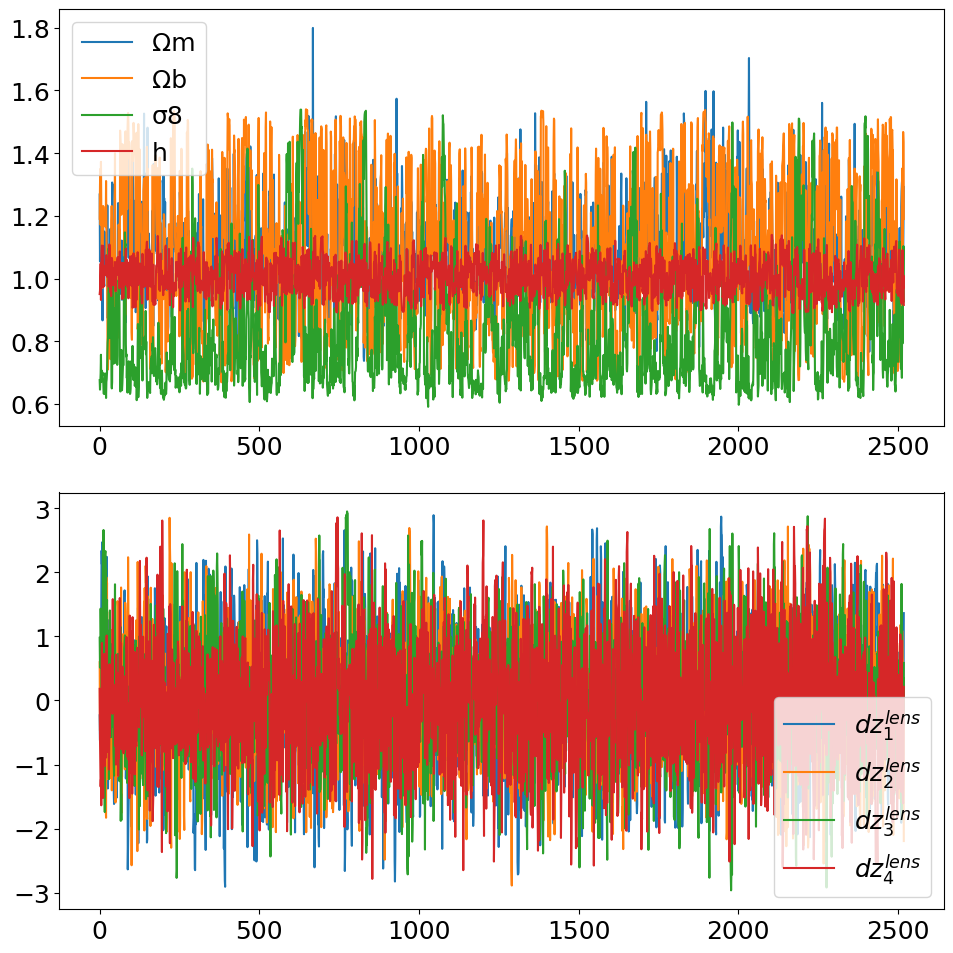

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
chain = chain_gcgc_nuisance_dz_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.2734714358876248, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.042170616570847225, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.7790071910238021, label="σ8")
axs[0].plot(np.array(chain["h"])/0.7189925511925751, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$dz^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens_1[1]"]), label=r"$dz^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens_2[1]"]), label=r"$dz^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens_3[1]"]), label=r"$dz^{lens}_4$")
axs[1].legend()

plt.tight_layout()
plt.show()

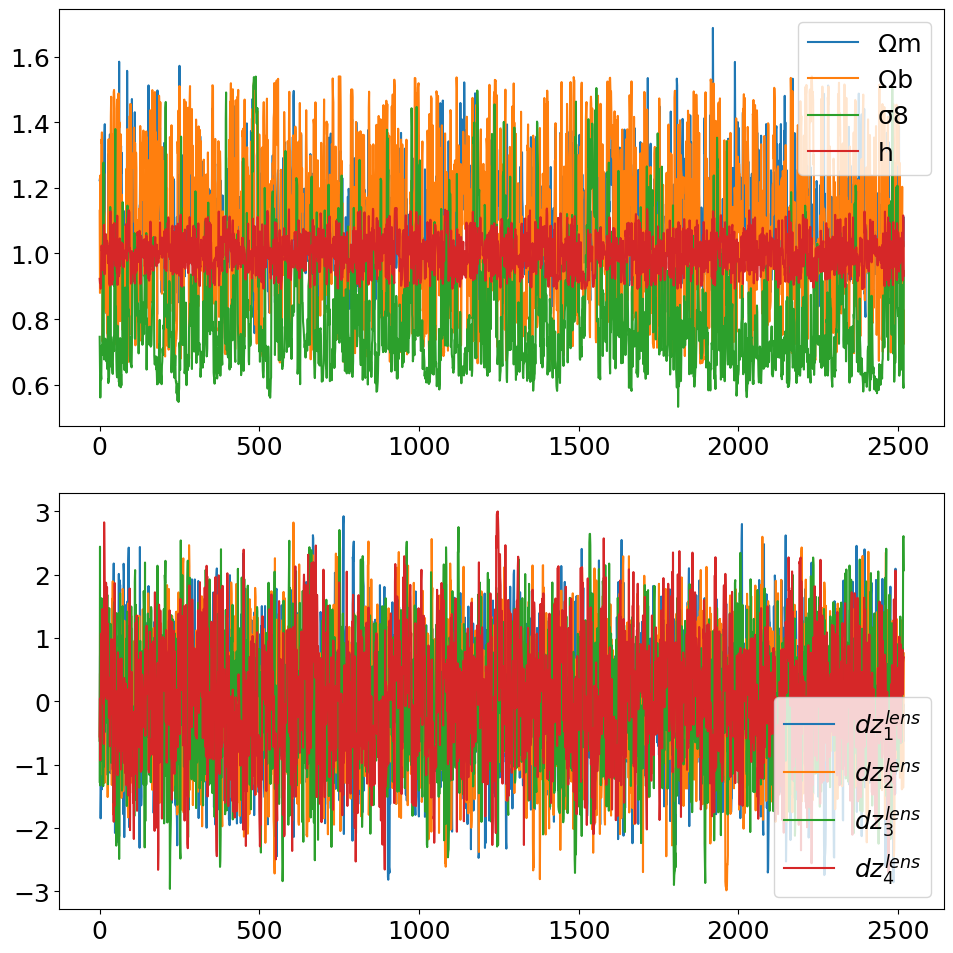

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
chain = chain_gcgc_nuisance_wzdz_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.2734714358876248, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.042170616570847225, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.7790071910238021, label="σ8")
axs[0].plot(np.array(chain["h"])/0.7189925511925751, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$dz^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens_1[1]"]), label=r"$dz^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens_2[1]"]), label=r"$dz^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens_3[1]"]), label=r"$dz^{lens}_4$")
axs[1].legend()

plt.tight_layout()
plt.show()

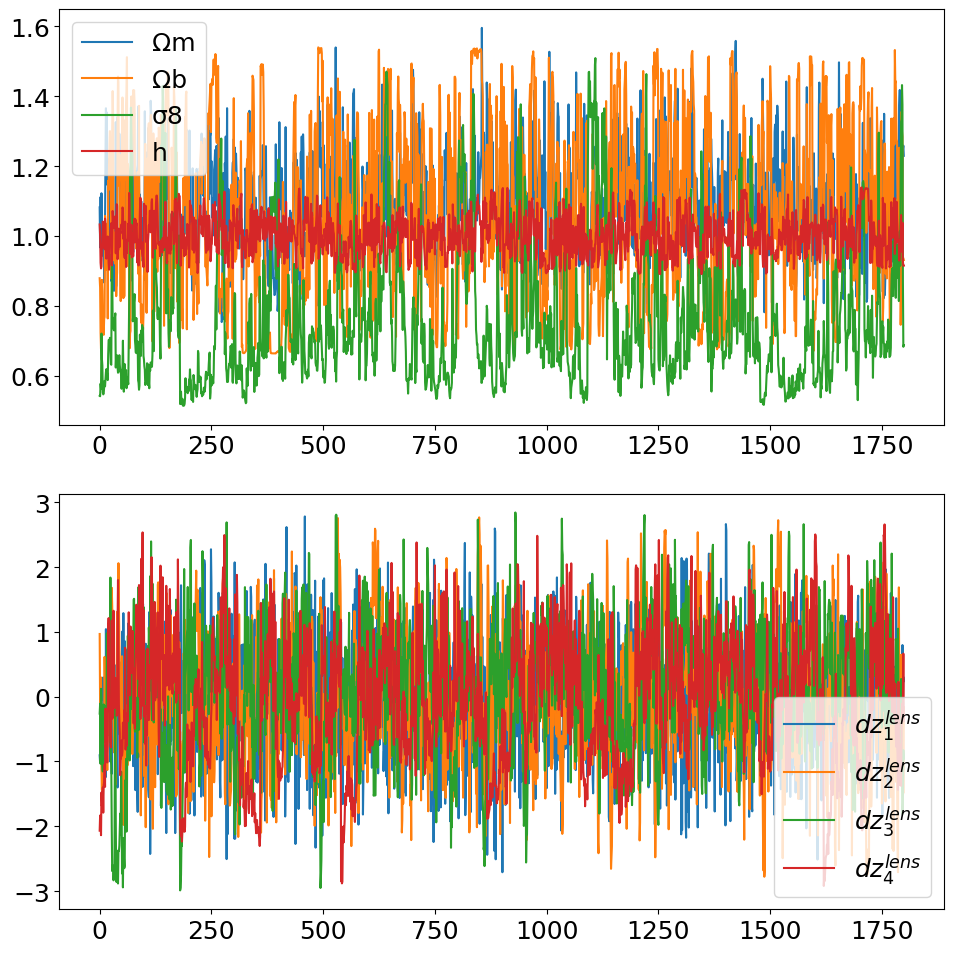

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
chain = chain_gcgc_nuisance_PCA_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.27347, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.04217, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.779007, label="σ8")
axs[0].plot(np.array(chain["h"])/0.71899, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$dz^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens_1[1]"]), label=r"$dz^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens_2[1]"]), label=r"$dz^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens_3[1]"]), label=r"$dz^{lens}_4$")
axs[1].legend()


plt.tight_layout()
plt.show()

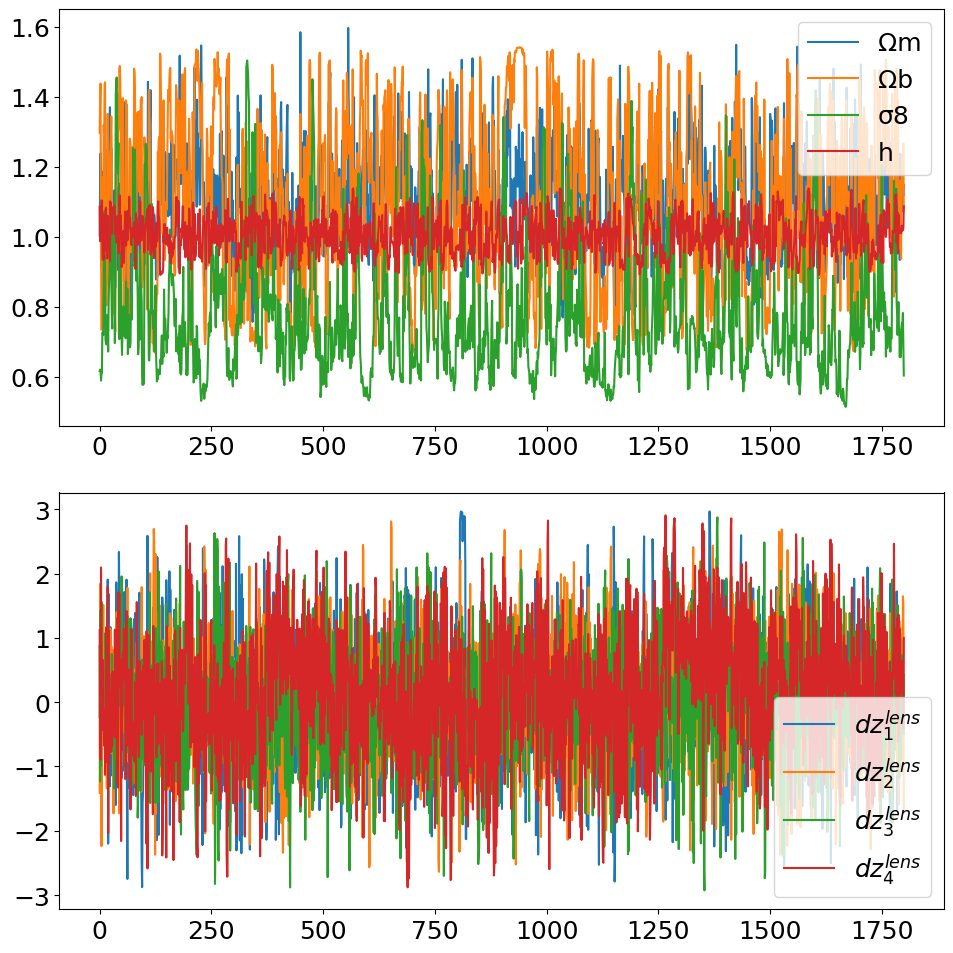

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
chain = chain_gcgc_nuisance_gp_num
# First plot
axs[0].plot(np.array(chain["Ωm"])/0.27347, label="Ωm")
axs[0].plot(np.array(chain["Ωb"])/0.04217, label="Ωb")
axs[0].plot(np.array(chain["σ8"])/0.779007, label="σ8")
axs[0].plot(np.array(chain["h"])/0.71899, label="h")
axs[0].legend()
# Second plot
axs[1].plot(np.array(chain["alphas_lens_0[1]"]), label=r"$dz^{lens}_1$")
axs[1].plot(np.array(chain["alphas_lens_1[1]"]), label=r"$dz^{lens}_2$")
axs[1].plot(np.array(chain["alphas_lens_2[1]"]), label=r"$dz^{lens}_3$")
axs[1].plot(np.array(chain["alphas_lens_3[1]"]), label=r"$dz^{lens}_4$")
axs[1].legend()

plt.tight_layout()
plt.show()

## Posteriors

In [19]:
labels_dict = {'h': 'h',
               'Ωm': r'\Omega_m',
               'Ωb': r'\Omega_b',
               'ns': 'n_s',
               'σ8': r'\sigma_8',
               'S8': 'S_8',

               'lens_0_b': r'b_{lens}^{0}',
               'lens_1_b': r'b_{lens}^{1}',
               'lens_2_b': r'b_{lens}^{2}',
               'lens_3_b': r'b_{lens}^{3}',
               'lens_4_b': r'b_{lens}^{4}',

               'dz_lens_0': r'\Delta^{0}_{z, lens}',
               'dz_lens_1': r'\Delta^{1}_{z, lens}',
               'dz_lens_2': r'\Delta^{2}_{z, lens}',
               'dz_lens_3': r'\Delta^{3}_{z, lens}',
               'dz_lens_4': r'\Delta^{4}_{z, lens}',

               'wz_lens_0': r'w^{0}_{z, lens}',
               'wz_lens_1': r'w^{1}_{z, lens}',
               'wz_lens_2': r'w^{2}_{z, lens}',
               'wz_lens_3': r'w^{3}_{z, lens}',
               'wz_lens_4': r'w^{4}_{z, lens}',
               
               'Xi2': r'\chi^2',}

In [20]:
def make_chain(file, label, ranges=dict({}), weight=False, labels_dict=labels_dict):
    params = np.array(list(file.keys()))
    names = []
    labels = []
    samples = []
    print(label)
    for param in params:
        #print(param)
        if param in labels_dict.keys():
            #print(param)
            names.append(param) 
            labels.append(labels_dict[param]) 
            samples.append(file[param])
    if ('σ8' in params) & ('Ωm' in params):
        #print('S8')
        names.append('S8')
        labels.append(labels_dict['S8'])
        samples.append(file['σ8']*np.sqrt(file['Ωm']/0.3))

    names = np.array(names)
    labels = np.array(labels)
    samples = np.transpose(np.array(samples))
    if weight == True:
        if "log_density" in params:
            print("applying weights")
            ws = np.array(file['log_density'])
    else:
        ws = None
    print("========")

    return MCSamples(samples=samples, names=names, labels=labels, label=label, ranges=ranges, weights=ws,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.5, 'smooth_scale_1D':0.5})
    

In [21]:
samples_wzdz_prior = make_chain(prior_wzdz_chain, r"Prior - $\Delta_z + w_z$ ", labels_dict=labels_dict)

Prior - $\Delta_z + w_z$ 
Removed no burn in


In [22]:
samples_gcgc_nuisance_nomarg = make_chain(chain_gcgc_nuisance_nomarg, "Fixed")

Fixed
Removed no burn in


In [23]:
samples_gcgc_nuisance_dz_ana = make_chain(chain_gcgc_nuisance_dz_ana, r"GCGC - $\Delta_z$ Analytical")
samples_gcgc_nuisance_wzdz_ana = make_chain(chain_gcgc_nuisance_wzdz_ana, r"GCGC - $\Delta_z + w_z$ Analytical")
samples_gcgc_nuisance_PCA_ana = make_chain(chain_gcgc_nuisance_PCA_ana, r"GCGC - PCA Analytical")
samples_gcgc_nuisance_gp_ana = make_chain(chain_gcgc_nuisance_gp_ana, r"GCGC - GP Analytical")

GCGC - $\Delta_z$ Analytical
Removed no burn in
GCGC - $\Delta_z + w_z$ Analytical
Removed no burn in
GCGC - PCA Analytical
Removed no burn in
GCGC - GP Analytical
Removed no burn in


In [24]:
samples_gcgc_nuisance_dz_num = make_chain(chain_gcgc_nuisance_dz_num, r"GCGC - $\Delta_z$ Numerical")
samples_gcgc_nuisance_wz_num = make_chain(chain_gcgc_nuisance_wz_num, r"GCGC - $w_z$ Numerical")
samples_gcgc_nuisance_wzdz_num = make_chain(chain_gcgc_nuisance_wzdz_num, r"GCGC - $\Delta_z + w_z$ Numerical")
samples_gcgc_nuisance_PCA_num = make_chain(chain_gcgc_nuisance_PCA_num, r"GCGC - PCA Numerical")
samples_gcgc_nuisance_gp_num = make_chain(chain_gcgc_nuisance_gp_num, r"GCGC - GP Numerical")

GCGC - $\Delta_z$ Numerical
Removed no burn in
GCGC - $w_z$ Numerical
Removed no burn in
GCGC - $\Delta_z + w_z$ Numerical
Removed no burn in
GCGC - PCA Numerical
Removed no burn in
GCGC - GP Numerical
Removed no burn in


In [25]:
prat_markers = {'h': 0.7189925511925751,
               'Ωm': 0.2734714358876248,
               'Ωb': 0.042170616570847225,
               'ns': 0.9965136823002241,
               'σ8': 0.7790071910238021,
               'lens_0_b':0.879118,
               'lens_1_b':1.05894, 
               'lens_2_b':1.22145, 
               'lens_3_b':1.35065, 
               'lens_4_b':1.58909}
prat_markers['S8'] = prat_markers['σ8']*np.sqrt(prat_markers['Ωm']/0.3)

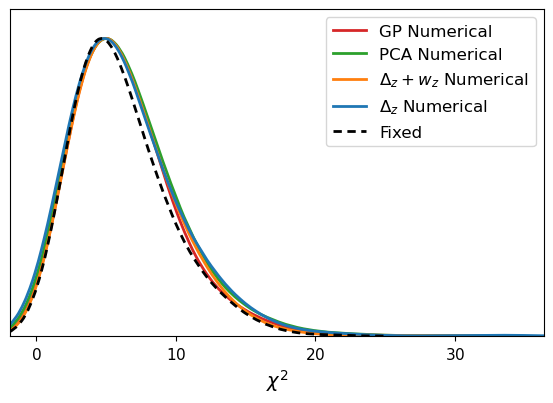

In [26]:
g = plots.get_single_plotter(width_inch=6)
g.plot_1d([
    samples_gcgc_nuisance_gp_num,
    samples_gcgc_nuisance_PCA_num,
    samples_gcgc_nuisance_wzdz_num,
    samples_gcgc_nuisance_dz_num,
    samples_gcgc_nuisance_nomarg,
    ], 'Xi2',
    colors=['C3', 'C2', 'C1', 'C0', "black"],
    ls=['-', '-', '-', '-', '--'], 
    lws=2)
g.add_legend(['GP Numerical', 'PCA Numerical', r'$\Delta_z + w_z$ Numerical', r'$\Delta_z$ Numerical', 'Fixed'])

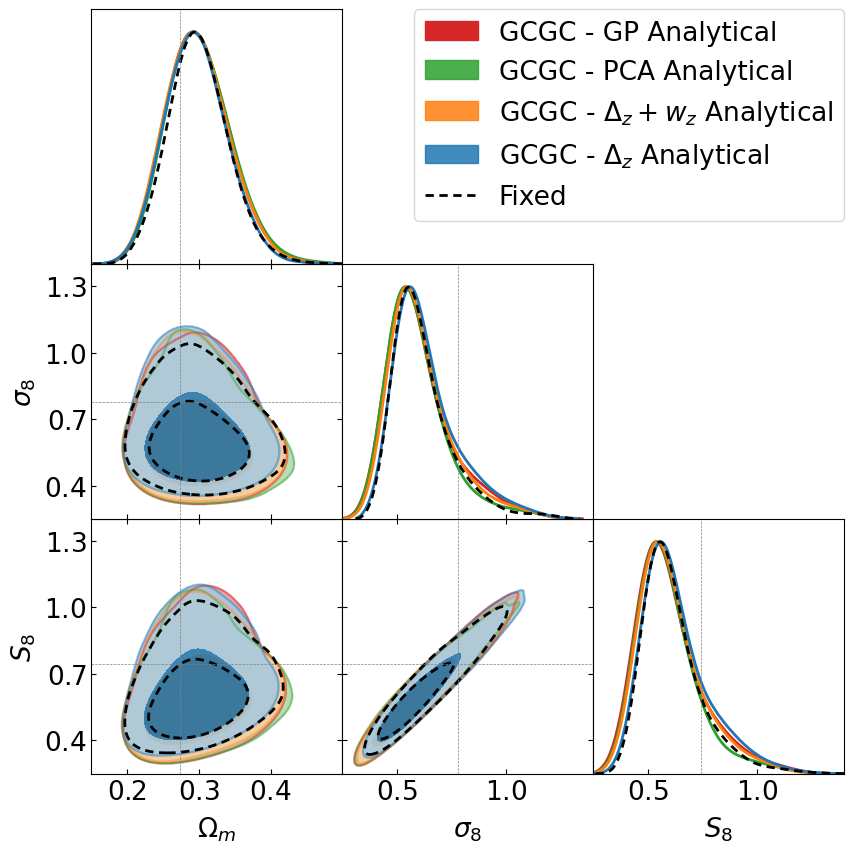

In [27]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_gp_ana,
    samples_gcgc_nuisance_PCA_ana,
    samples_gcgc_nuisance_wzdz_ana,
    samples_gcgc_nuisance_dz_ana,
    samples_gcgc_nuisance_nomarg,
    ],
    ['Ωm', 'σ8', 'S8'],
    line_args=[
            {'color':'C3'},
            {'color':'C2'},
            {'color':'C1'},
            {'color':'C0'},
            {'color':'black'}], 
    colors=['C3', 'C2', 'C1', 'C0', "black"],
    param_limits={'Ωm':(0.15, 0.5), 'σ8':(0.25, 1.4), 'S8':(0.25, 1.4)},
    filled=[True, True, True, True, False],
    contour_ls=['-', '-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

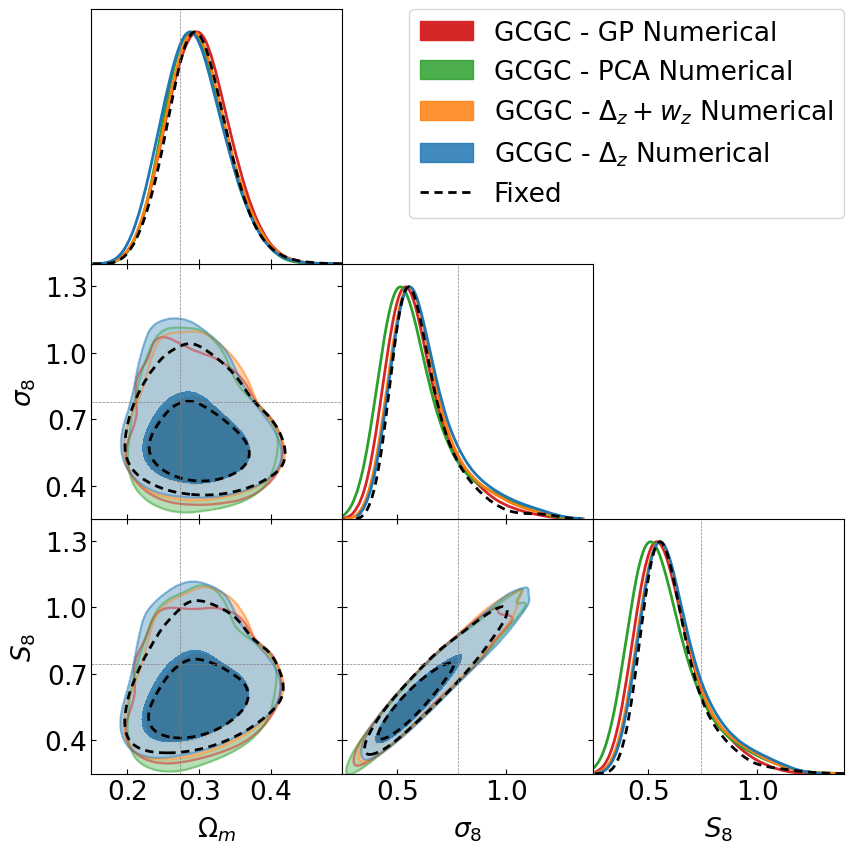

In [28]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_gp_num,
    samples_gcgc_nuisance_PCA_num,
    samples_gcgc_nuisance_wzdz_num,
    samples_gcgc_nuisance_dz_num,
    samples_gcgc_nuisance_nomarg,
    ],
    ['Ωm', 'σ8', 'S8'],
    line_args=[
            {'color':'C3'},
            {'color':'C2'},
            {'color':'C1'},
            {'color':'C0'},
            {'color':'black'}], 
    colors=['C3', 'C2', 'C1', 'C0', "black"],
    param_limits={'Ωm':(0.15, 0.5), 'σ8':(0.25, 1.4), 'S8':(0.25, 1.4)},
    filled=[True, True, True, True, False],
    contour_ls=['-', '-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

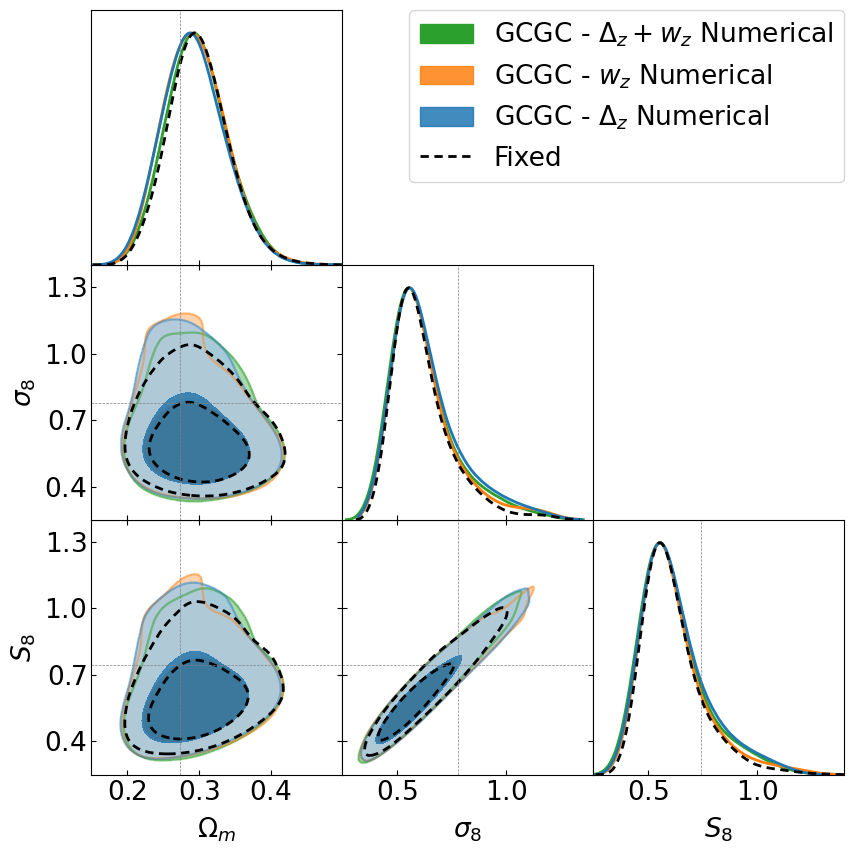

In [29]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_wzdz_num,
    samples_gcgc_nuisance_wz_num,
    samples_gcgc_nuisance_dz_num,
    samples_gcgc_nuisance_nomarg,
    ],
    ['Ωm', 'σ8', 'S8'],
    line_args=[
            {'color':'C2'},
            {'color':'C1'},
            {'color':'C0'},
            {'color':'black'}], 
    colors=['C2', 'C1', 'C0', "black"],
    param_limits={'Ωm':(0.15, 0.5), 'σ8':(0.25, 1.4), 'S8':(0.25, 1.4)},
    filled=[True, True, True, False],
    contour_ls=['-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

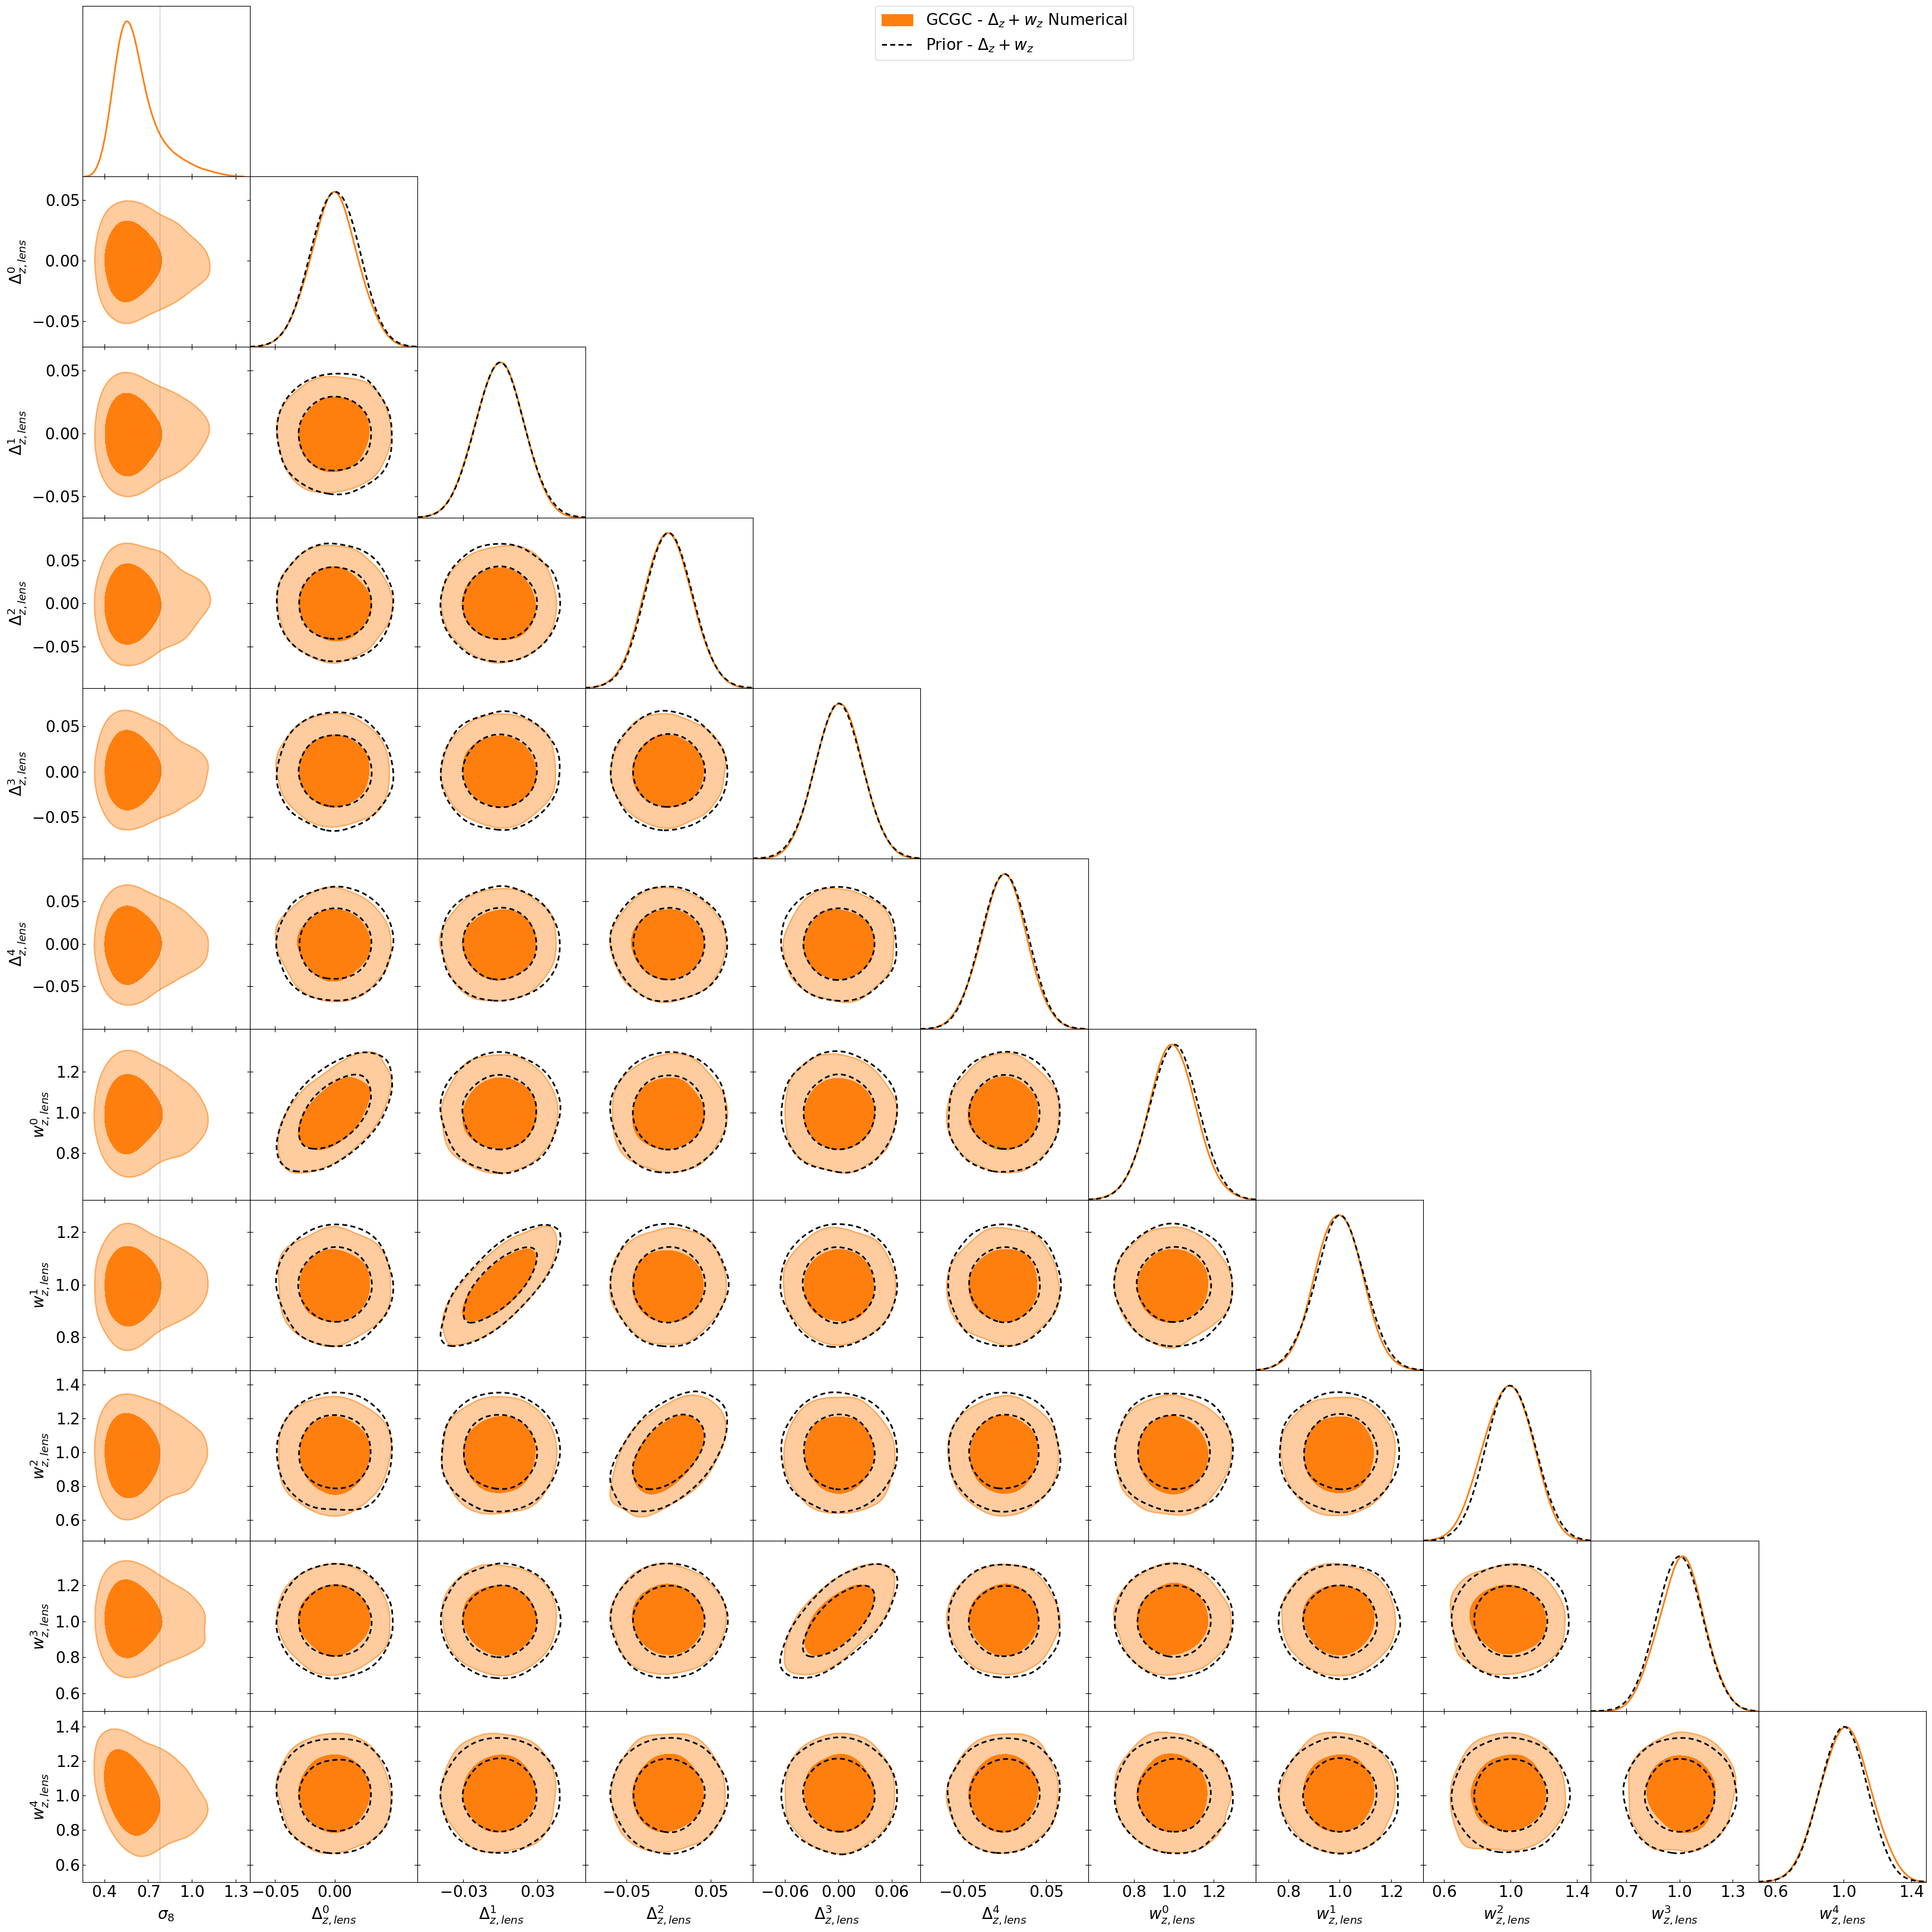

In [30]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_wzdz_num,
    samples_wzdz_prior,
    ],
    ['σ8', 
     'dz_lens_0',
     'dz_lens_1',
     'dz_lens_2',
     'dz_lens_3',
     'dz_lens_4',
     'wz_lens_0',
     'wz_lens_1',
     'wz_lens_2',
     'wz_lens_3',
     'wz_lens_4',],
    line_args=[
            {'color':'C1'},
            {'color':'black'}], 
    colors=['C1',  "black"],
    param_limits={'σ8':(0.25, 1.4), 
                    'lens_0_b':(0.3, 2.3),
                    'lens_1_b':(0.4, 2.5),
                    'lens_2_b':(0.5, 2.7),
                    'lens_3_b':(0.5, 3.0),
                    'lens_4_b':(0.6, 3.0),
                  },
    filled=[True, False],
    contour_ls=['-','--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

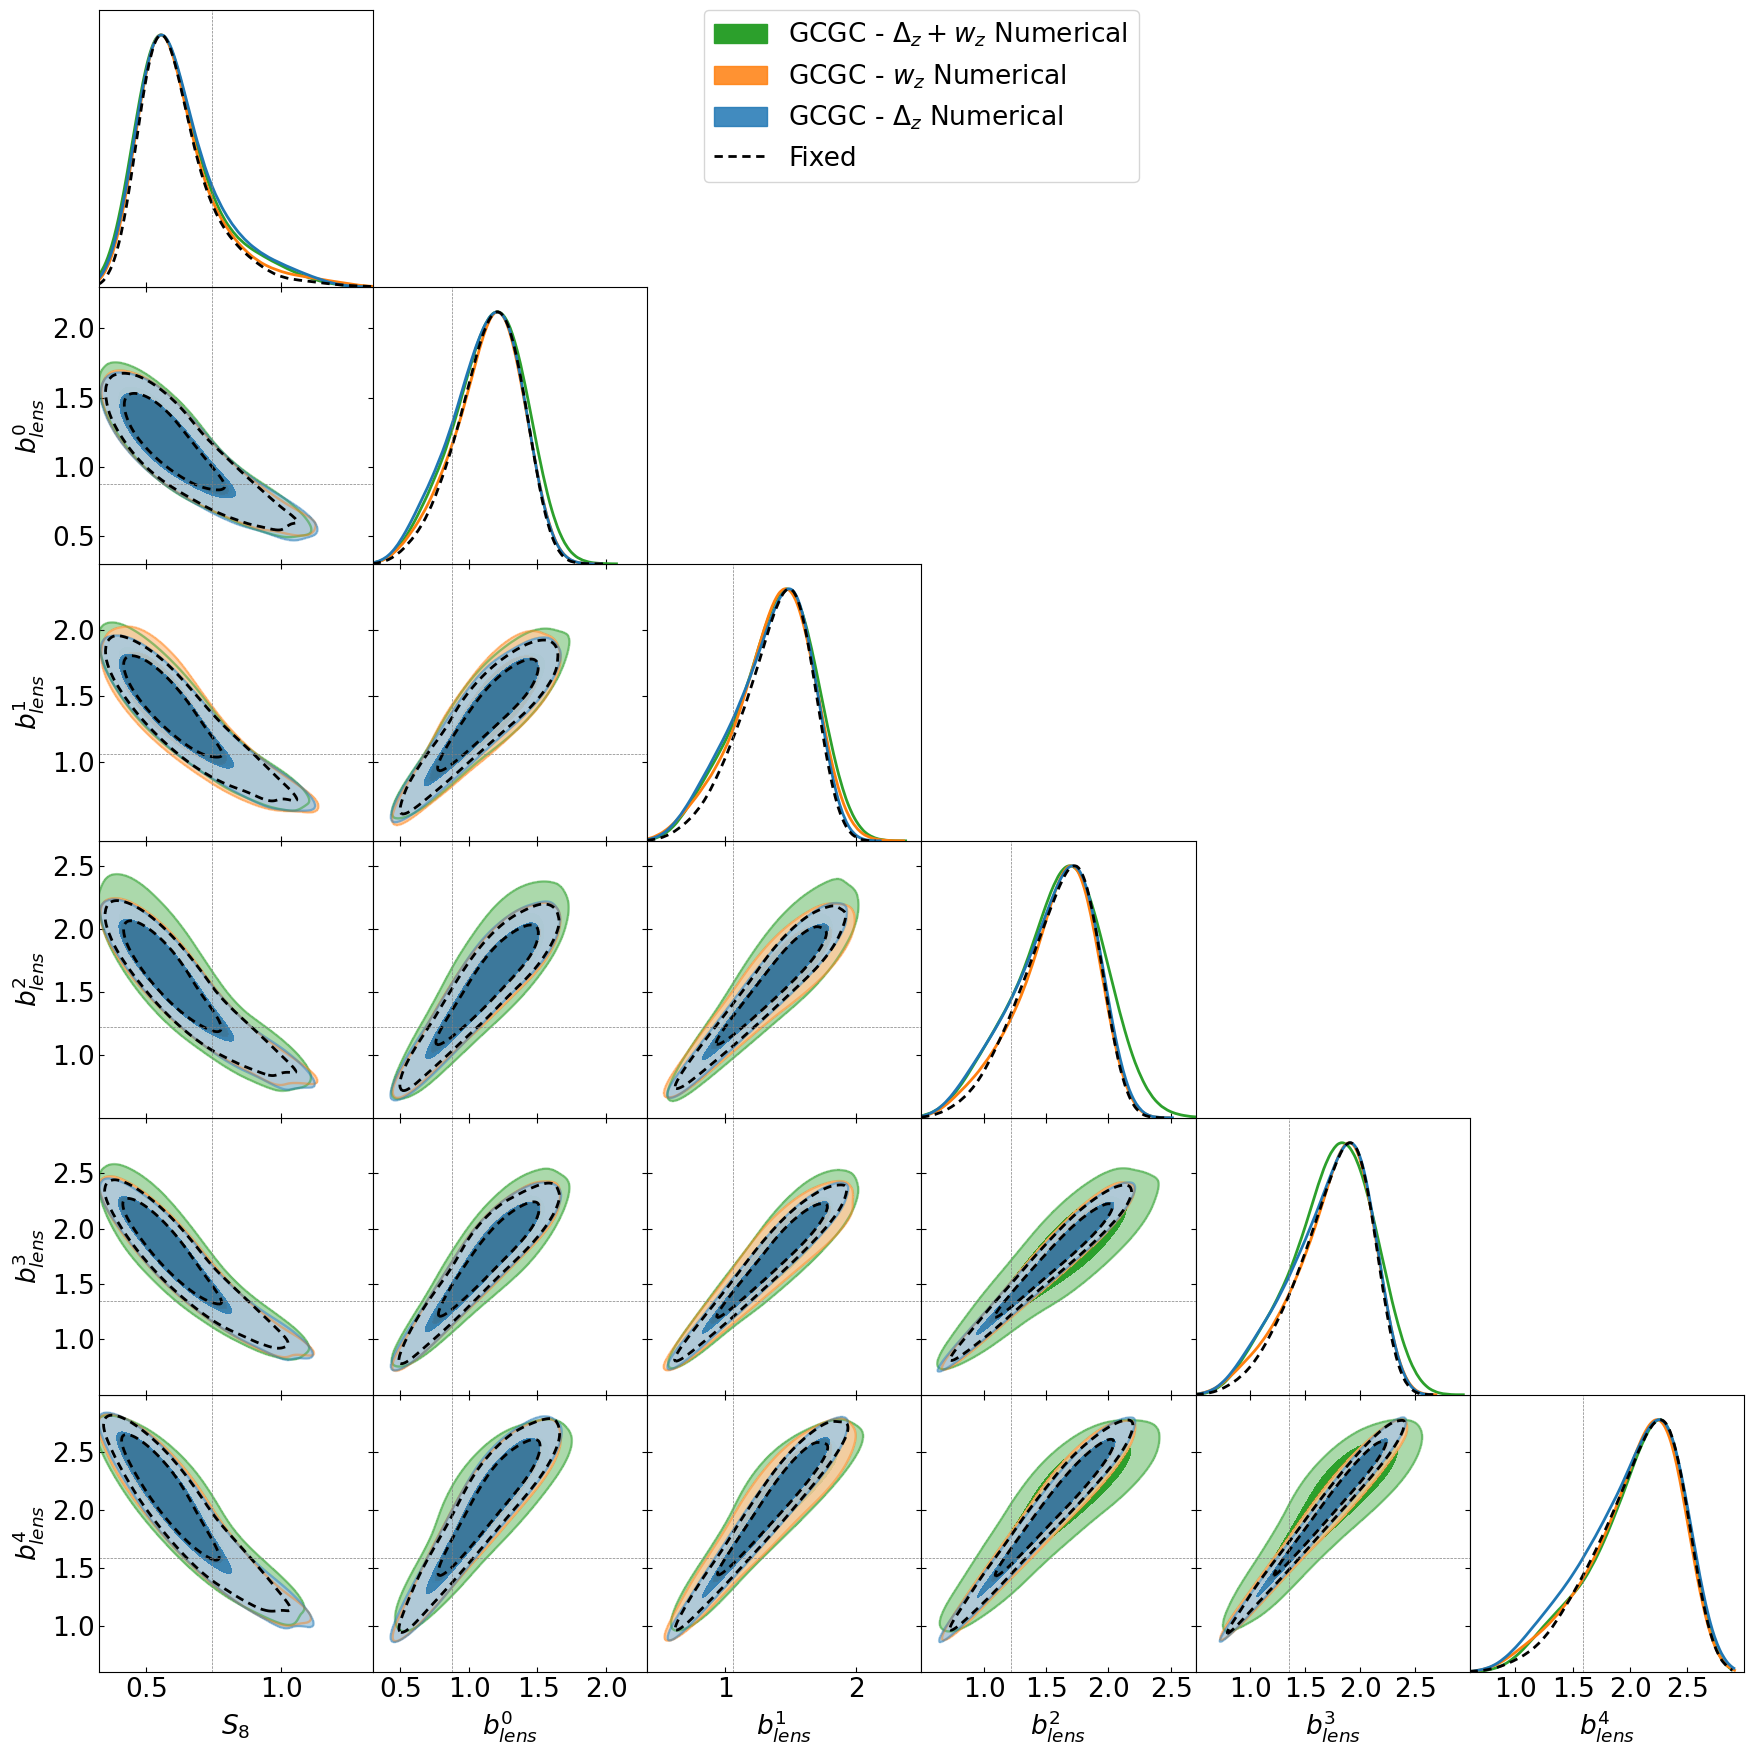

In [31]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_wzdz_num,
    samples_gcgc_nuisance_wz_num,
    samples_gcgc_nuisance_dz_num,
    samples_gcgc_nuisance_nomarg,
    ],
    ['S8', 
     'lens_0_b', 
      'lens_1_b',
      'lens_2_b',
      'lens_3_b',
     'lens_4_b',],
    line_args=[
            {'color':'C2'},
            {'color':'C1'},
            {'color':'C0'},
            {'color':'black'}], 
    colors=['C2', 'C1', 'C0', "black"],
    param_limits={'σ8':(0.25, 1.4), 
                    'lens_0_b':(0.3, 2.3),
                    'lens_1_b':(0.4, 2.5),
                    'lens_2_b':(0.5, 2.7),
                    'lens_3_b':(0.5, 3.0),
                    'lens_4_b':(0.6, 3.0),
                  },
    filled=[ True, True, True, False],
    contour_ls=[ '-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

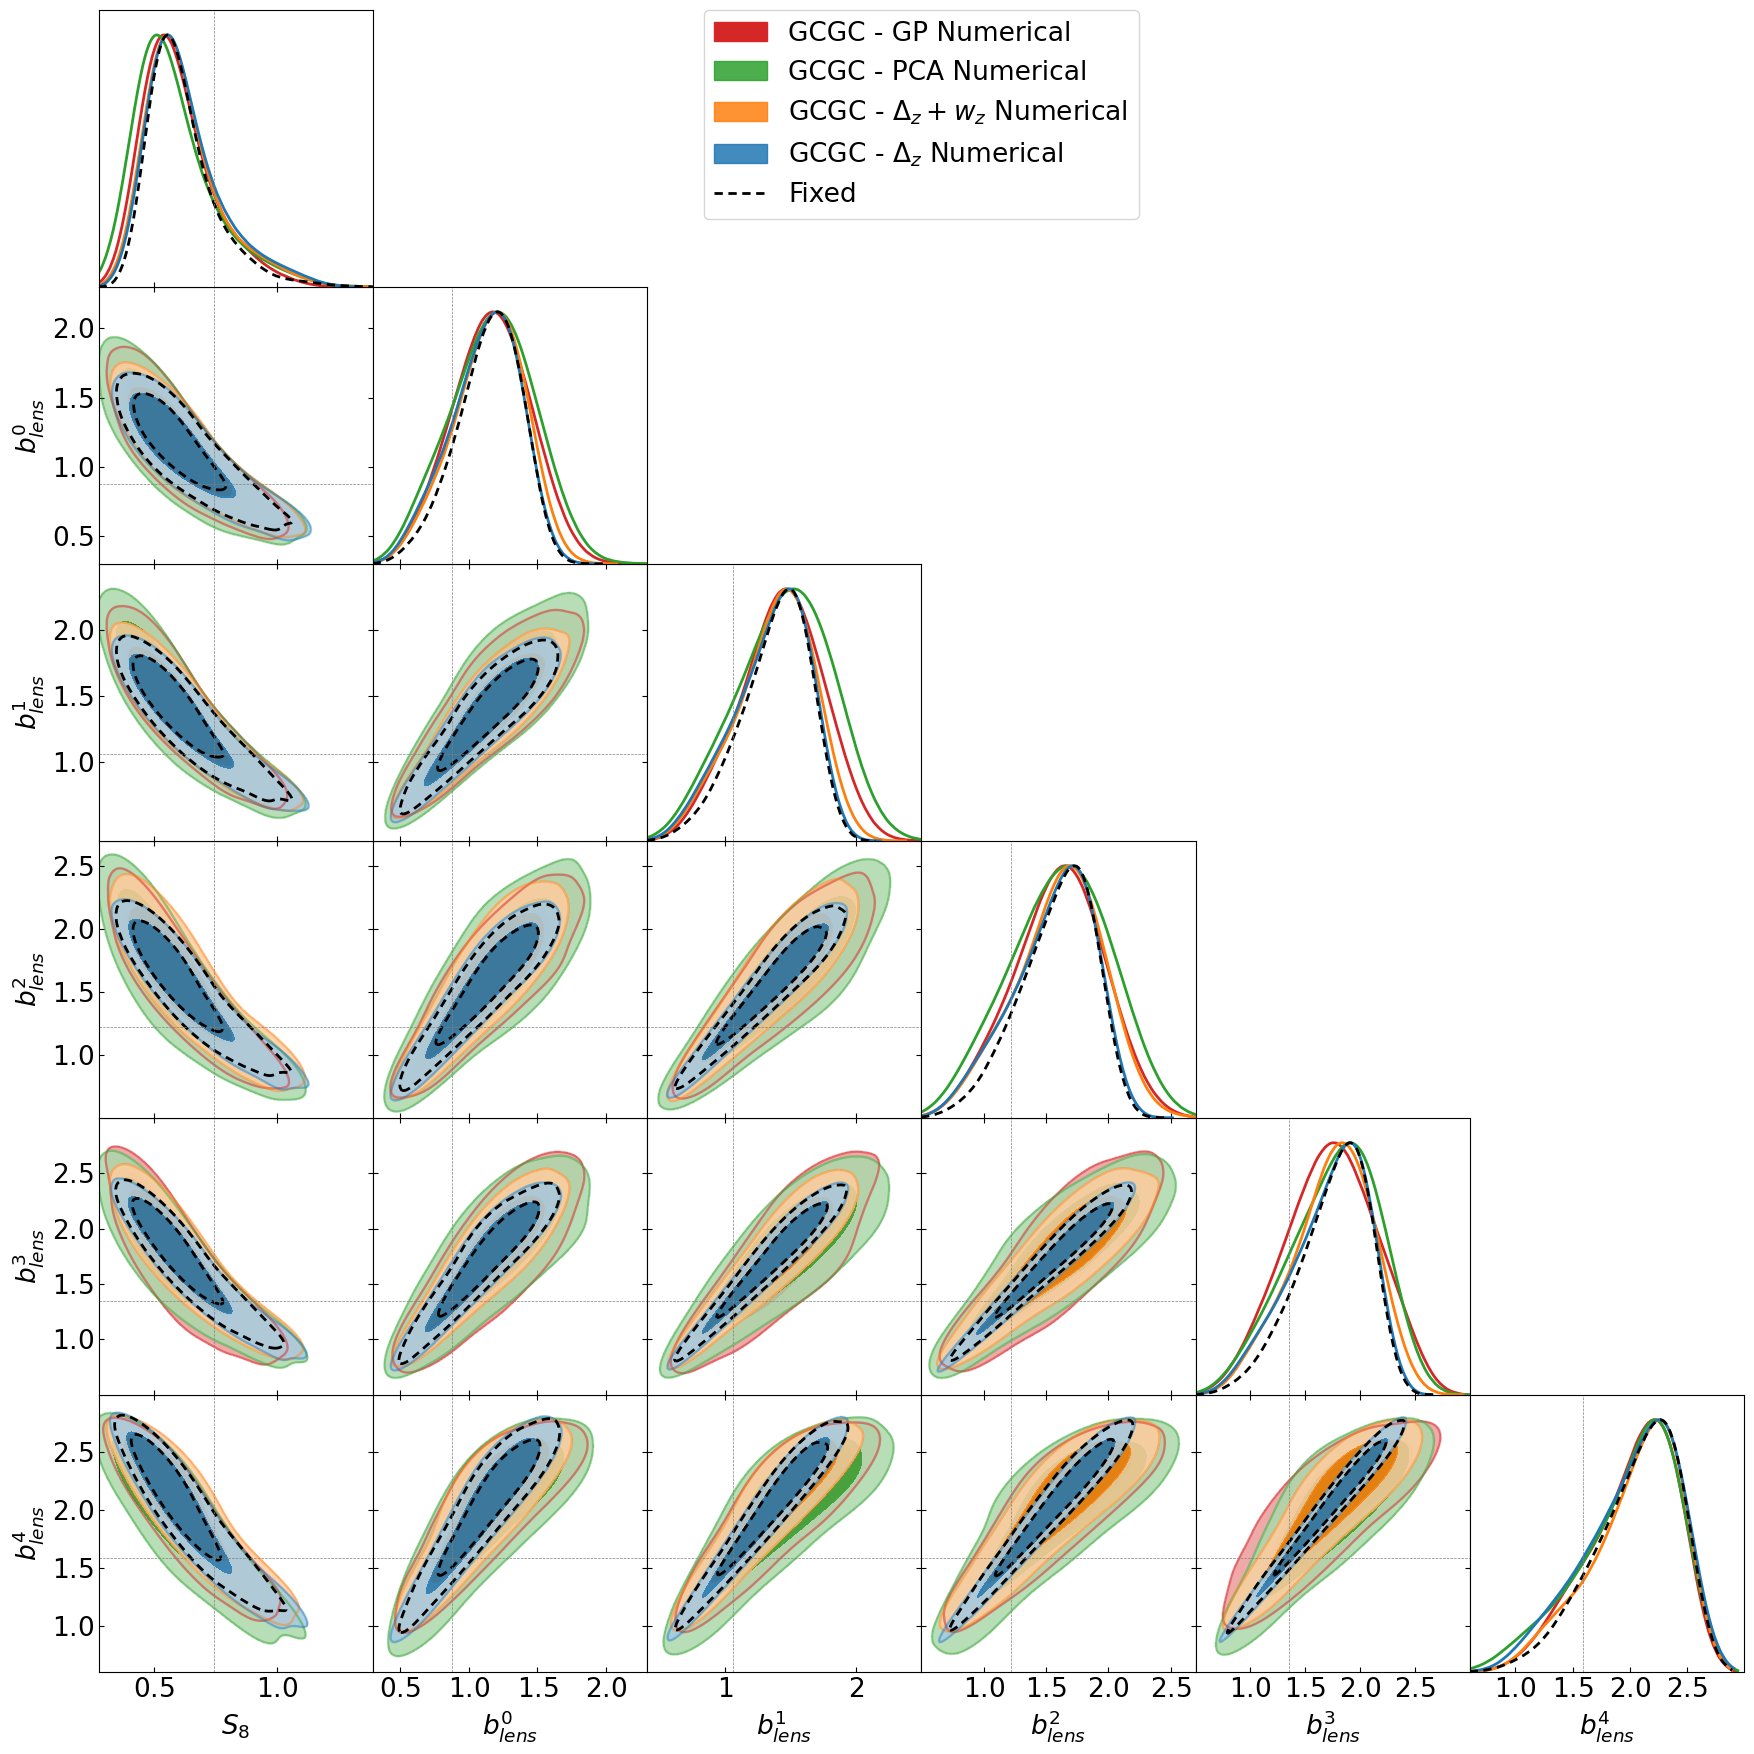

In [32]:
g = plots.getSubplotPlotter(subplot_size=3)
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.triangle_plot([
    samples_gcgc_nuisance_gp_num,
    samples_gcgc_nuisance_PCA_num,
    samples_gcgc_nuisance_wzdz_num,
    samples_gcgc_nuisance_dz_num,
    samples_gcgc_nuisance_nomarg,
    ],
    ['S8', 
     'lens_0_b', 
      'lens_1_b',
      'lens_2_b',
      'lens_3_b',
     'lens_4_b',],
    line_args=[
            {'color':'C3'},
            {'color':'C2'},
            {'color':'C1'},
            {'color':'C0'},
            {'color':'black'}], 
    colors=['C3', 'C2', 'C1', 'C0', "black"],
    param_limits={'σ8':(0.25, 1.4), 
                    'lens_0_b':(0.3, 2.3),
                    'lens_1_b':(0.4, 2.5),
                    'lens_2_b':(0.5, 2.7),
                    'lens_3_b':(0.5, 3.0),
                    'lens_4_b':(0.6, 3.0),
                  },
    filled=[True, True, True, True, False],
    contour_ls=['-', '-', '-', '-', '--'], 
    contour_lws=2,
    markers=prat_markers)
#g.export("./paper_plots/triangle_comp.pdf")

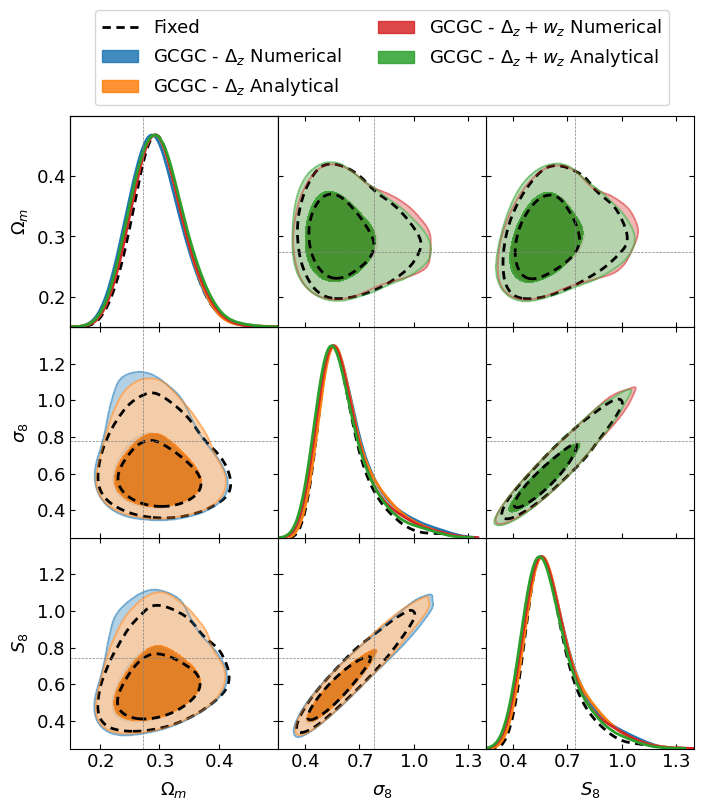

In [33]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 15
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([samples_gcgc_nuisance_nomarg,
                samples_gcgc_nuisance_dz_num,
                samples_gcgc_nuisance_dz_ana,
                 ],
                 ['Ωm', 'σ8', 'S8'],
                 upper_roots = [samples_gcgc_nuisance_nomarg,
                                samples_gcgc_nuisance_wzdz_num,
                                samples_gcgc_nuisance_wzdz_ana,
                                ],
                 upper_kwargs = {'contour_colors':['black', 'C3', 'C2'],
                                'contour_ls': ['--', '-', '-'], 
                                    'filled': [False, True, True],
                                    'contour_lws':2}, 
                line_args=[{'color':'black'},
                           {'color':'C0'},
                           {'color':'C1'}], 
                colors=["black", 'C0', 'C1'],
                param_limits={'Ωm':(0.15, 0.5), 'σ8':(0.25, 1.4), 'S8':(0.25, 1.4)},
                filled=[False, True, True],
                contour_ls=['--', '-', '-'], 
                contour_lws=2,
                legend_ncol=2,
                 markers=prat_markers)
#g.export("./paper_plots/triangle_1.pdf")

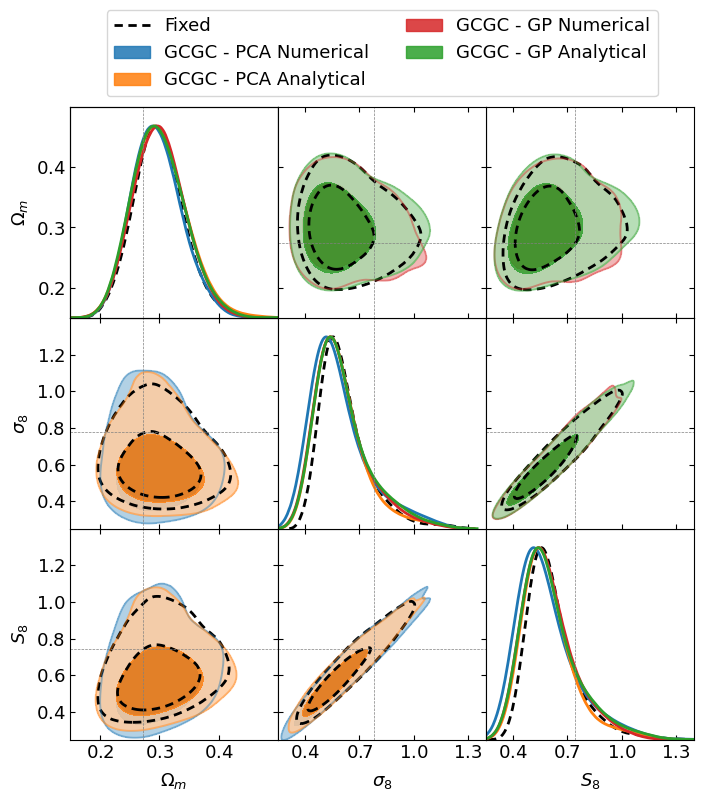

In [34]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.settings.axes_fontsize = 15
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([samples_gcgc_nuisance_nomarg,
                 samples_gcgc_nuisance_PCA_num,
                 samples_gcgc_nuisance_PCA_ana,
                 ],
                 ['Ωm', 'σ8', 'S8'],
                 upper_roots = [samples_gcgc_nuisance_nomarg,
                                samples_gcgc_nuisance_gp_num,
                                samples_gcgc_nuisance_gp_ana,
                                ],
                 upper_kwargs = {'contour_colors':['black', 'C3', 'C2'],
                                'contour_ls': ['--', '-', '-'], 
                                    'filled': [False, True, True],
                                    'contour_lws':2}, 
                line_args=[{'color':'black'},
                           {'color':'C0'},
                           {'color':'C1'}], 
                colors=["black", 'C0', 'C1'],
                param_limits={'Ωm':(0.15, 0.5), 'σ8':(0.25, 1.4), 'S8':(0.25, 1.4)},
                filled=[False, True, True],
                contour_ls=['--', '-', '-'], 
                contour_lws=2,
                legend_ncol=2,
                 markers=prat_markers)
#g.export("./paper_plots/triangle_2.pdf")

In [35]:
def make_table(params):
    for param in params:
        if param == "S8":
            param_nomarg = chain_gcgc_nuisance_nomarg["σ8"] * np.sqrt(chain_gcgc_nuisance_nomarg["Ωm"] / 0.3)
            param_dz_ana = chain_gcgc_nuisance_dz_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_dz_ana["Ωm"] / 0.3)
            param_wzdz_ana = chain_gcgc_nuisance_wzdz_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_wzdz_ana["Ωm"] / 0.3)
            param_PCA_ana = chain_gcgc_nuisance_PCA_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_PCA_ana["Ωm"] / 0.3)
            param_gp_ana = chain_gcgc_nuisance_gp_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_gp_ana["Ωm"] / 0.3)
            param_dz_num = chain_gcgc_nuisance_dz_num["σ8"] * np.sqrt(chain_gcgc_nuisance_dz_num["Ωm"] / 0.3)
            param_wzdz_num = chain_gcgc_nuisance_wzdz_num["σ8"] * np.sqrt(chain_gcgc_nuisance_wzdz_num["Ωm"] / 0.3) 
            param_PCA_num = chain_gcgc_nuisance_PCA_num["σ8"] * np.sqrt(chain_gcgc_nuisance_PCA_num["Ωm"] / 0.3)
            param_gp_num = chain_gcgc_nuisance_gp_num["σ8"]  * np.sqrt(chain_gcgc_nuisance_gp_num["Ωm"] / 0.3)
        else:
            param_nomarg = chain_gcgc_nuisance_nomarg[param]
            param_dz_ana = chain_gcgc_nuisance_dz_ana[param]
            param_wzdz_ana = chain_gcgc_nuisance_wzdz_ana[param]
            param_PCA_ana = chain_gcgc_nuisance_PCA_ana[param]
            param_gp_ana = chain_gcgc_nuisance_gp_ana[param]
            param_dz_num = chain_gcgc_nuisance_dz_num[param]
            param_wzdz_num = chain_gcgc_nuisance_wzdz_num[param]
            param_PCA_num = chain_gcgc_nuisance_PCA_num[param]
            param_gp_num = chain_gcgc_nuisance_gp_num[param]

        print("$", labels_dict[param], "$",
            "&", np.round(np.mean(param_nomarg),3), "$\pm$", np.round(np.std(param_nomarg),3),
            "&", np.round(np.mean(param_dz_ana),3), "$\pm$", np.round(np.std(param_dz_ana),3),
            "&", np.round(np.mean(param_wzdz_ana),3), "$\pm$", np.round(np.std(param_wzdz_ana),3),
            "&", np.round(np.mean(param_PCA_ana),3), "$\pm$", np.round(np.std(param_PCA_ana),3),
            "&", np.round(np.mean(param_gp_ana),3), "$\pm$", np.round(np.std(param_gp_ana),3),
            "&", np.round(np.mean(param_dz_num),3), "$\pm$", np.round(np.std(param_dz_num),3),
            "&", np.round(np.mean(param_wzdz_num),3), "$\pm$", np.round(np.std(param_wzdz_num),3),
            "&", np.round(np.mean(param_PCA_num),3), "$\pm$", np.round(np.std(param_PCA_num),3),
            "&", np.round(np.mean(param_gp_num),3), "$\pm$", np.round(np.std(param_gp_num),3),
            "\\\\")

<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_103204/1951482936.py:25: SyntaxWarning: invalid escape sequence '\p

In [36]:
make_table(["Ωm", "σ8", "S8", "Ωb", "h", "ns", "lens_0_b", "lens_1_b", "lens_2_b", "lens_3_b", "lens_4_b"])

$ \Omega_m $ & 0.3 $\pm$ 0.038 & 0.297 $\pm$ 0.039 & 0.298 $\pm$ 0.041 & 0.301 $\pm$ 0.042 & 0.3 $\pm$ 0.04 & 0.293 $\pm$ 0.04 & 0.298 $\pm$ 0.039 & 0.296 $\pm$ 0.038 & 0.3 $\pm$ 0.039 \\
$ \sigma_8 $ & 0.617 $\pm$ 0.128 & 0.636 $\pm$ 0.14 & 0.611 $\pm$ 0.137 & 0.595 $\pm$ 0.133 & 0.608 $\pm$ 0.142 & 0.638 $\pm$ 0.148 & 0.623 $\pm$ 0.142 & 0.591 $\pm$ 0.153 & 0.6 $\pm$ 0.136 \\
$ S_8 $ & 0.615 $\pm$ 0.128 & 0.63 $\pm$ 0.14 & 0.606 $\pm$ 0.137 & 0.594 $\pm$ 0.133 & 0.605 $\pm$ 0.145 & 0.628 $\pm$ 0.144 & 0.619 $\pm$ 0.142 & 0.585 $\pm$ 0.152 & 0.598 $\pm$ 0.133 \\
$ \Omega_b $ & 0.046 $\pm$ 0.01 & 0.046 $\pm$ 0.01 & 0.046 $\pm$ 0.01 & 0.046 $\pm$ 0.01 & 0.046 $\pm$ 0.011 & 0.046 $\pm$ 0.01 & 0.046 $\pm$ 0.01 & 0.045 $\pm$ 0.01 & 0.046 $\pm$ 0.01 \\
$ h $ & 0.72 $\pm$ 0.042 & 0.722 $\pm$ 0.039 & 0.72 $\pm$ 0.041 & 0.72 $\pm$ 0.041 & 0.722 $\pm$ 0.041 & 0.724 $\pm$ 0.041 & 0.719 $\pm$ 0.041 & 0.721 $\pm$ 0.042 & 0.723 $\pm$ 0.04 \\
$ n_s $ & 0.961 $\pm$ 0.073 & 0.966 $\pm$ 0.073 & 0.966 $

0.1277
0.1436
0.1403
0.1421
0.1366
0.152
0.1329
0.1334
0.1449
dz - fixed 0.08070169842417173
dz - wzddz 0.11970429600436798
dz - PCA 0.18811890835099196
dz - gp 0.121660936168925


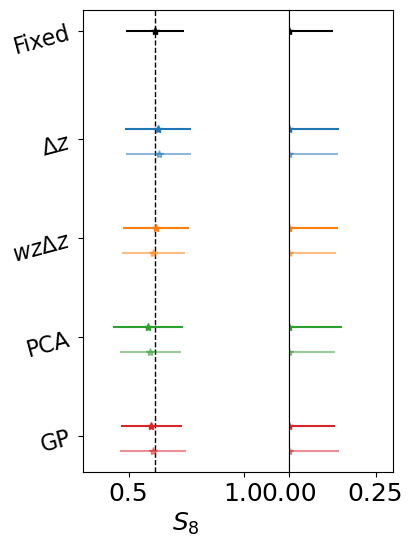

In [55]:
figure, axis = plt.subplots(1, 2, figsize=(4,6), gridspec_kw={"width_ratios": [2, 1]},)
figure.subplots_adjust(wspace=0, hspace=0.15)
my_yticks = ['Fixed', r'$\Delta z$',  r'$wz \Delta z$', 'PCA', 'GP']


label = r'$S_{\rm{8}}$'
p_fixed = chain_gcgc_nuisance_nomarg["σ8"] * np.sqrt(chain_gcgc_nuisance_nomarg["Ωm"] / 0.3)
p_fixed_m, p_fixed_s = np.mean(p_fixed), np.std(p_fixed)
print(round(p_fixed_s,4))
axis[0].errorbar(p_fixed_m, 0, xerr=np.transpose(p_fixed_s), color='k', fmt='*')
axis[1].errorbar(0, 0, xerr=np.transpose(p_fixed_s), color='k', fmt='*')
axis[0].axvline(p_fixed_m, ls='--', color='k', lw=1)
print("==============")
p_dz = chain_gcgc_nuisance_dz_num["σ8"] * np.sqrt(chain_gcgc_nuisance_dz_num["Ωm"] / 0.3)
p_dz_m, p_dz_s = np.mean(p_dz), np.std(p_dz)
print(round(p_dz_s, 4))
axis[0].errorbar(p_dz_m, 2, xerr=np.transpose(p_dz_s), color="C0", fmt='*')
axis[1].errorbar(0, 2, xerr=np.transpose(p_dz_s), color="C0", fmt='*')
p_dz = chain_gcgc_nuisance_dz_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_dz_ana["Ωm"] / 0.3)
p_dz_m, p_dz_s = np.mean(p_dz), np.std(p_dz)
print(round(p_dz_s, 4))
axis[0].errorbar(p_dz_m, 2.5, xerr=np.transpose(p_dz_s), color="C0", fmt='*', alpha=0.5)
axis[1].errorbar(0, 2.5, xerr=np.transpose(p_dz_s), color="C0", fmt='*', alpha=0.5)
print("==============")
p_wzdz = chain_gcgc_nuisance_wzdz_num["σ8"] * np.sqrt(chain_gcgc_nuisance_wzdz_num["Ωm"] / 0.3)
p_wzdz_m, p_wzdz_s = np.mean(p_wzdz), np.std(p_wzdz)
print(round(p_wzdz_s, 4))
axis[0].errorbar(p_wzdz_m, 4, xerr=np.transpose(p_wzdz_s), color="C1", fmt='*')
axis[1].errorbar(0, 4, xerr=np.transpose(p_wzdz_s), color="C1", fmt='*')
p_wzdz = chain_gcgc_nuisance_wzdz_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_wzdz_ana["Ωm"] / 0.3)
p_wzdz_m, p_wzdz_s = np.mean(p_wzdz), np.std(p_wzdz)
print(round(p_wzdz_s, 4))
axis[0].errorbar(p_wzdz_m, 4.5, xerr=np.transpose(p_wzdz_s), color="C1",  fmt='*', alpha=0.5)
axis[1].errorbar(0, 4.5, xerr=np.transpose(p_wzdz_s), color="C1",  fmt='*', alpha=0.5)
print("==============")
p_PCA = chain_gcgc_nuisance_PCA_num["σ8"] * np.sqrt(chain_gcgc_nuisance_PCA_num["Ωm"] / 0.3)
p_PCA_m, p_PCA_s = np.mean(p_PCA), np.std(p_PCA)
print(round(p_PCA_s, 4))
axis[0].errorbar(p_PCA_m, 6, xerr=np.transpose(p_PCA_s), color="C2",  fmt='*')
axis[1].errorbar(0, 6, xerr=np.transpose(p_PCA_s), color="C2", fmt='*')
p_PCA = chain_gcgc_nuisance_PCA_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_PCA_ana["Ωm"] / 0.3)
p_PCA_m, p_PCA_s = np.mean(p_PCA), np.std(p_PCA)
print(round(p_PCA_s, 4))
axis[0].errorbar(p_PCA_m, 6.5, xerr=np.transpose(p_PCA_s), color="C2", fmt='*', alpha=0.5)
axis[1].errorbar(0, 6.5, xerr=np.transpose(p_PCA_s), color="C2", fmt='*', alpha=0.5)
print("==============")
p_gp = chain_gcgc_nuisance_gp_num["σ8"] * np.sqrt(chain_gcgc_nuisance_gp_num["Ωm"] / 0.3)
p_gp_m, p_gp_s = np.mean(p_gp), np.std(p_gp)
print(round(p_gp_s, 4))
axis[0].errorbar(p_gp_m, 8, xerr=np.transpose(p_gp_s), color="C3", fmt='*')
axis[1].errorbar(0, 8, xerr=np.transpose(p_gp_s), color="C3", fmt='*')
p_gp = chain_gcgc_nuisance_gp_ana["σ8"] * np.sqrt(chain_gcgc_nuisance_gp_ana["Ωm"] / 0.3)
p_gp_m, p_gp_s = np.mean(p_gp), np.std(p_gp)
print(round(p_gp_s, 4))
axis[0].errorbar(p_gp_m, 8.5, xerr=np.transpose(p_gp_s), color="C3", fmt='*', alpha=0.5)
axis[1].errorbar(0, 8.5, xerr=np.transpose(p_gp_s), color="C3", fmt='*', alpha=0.5)
print("==============")
diff_fixed_dz = np.abs(p_fixed_m - p_dz_m)/np.sqrt(p_fixed_s**2 + p_dz_s**2)
diff_dz_wzddz = np.abs(p_dz_m - p_wzdz_m)/np.sqrt(p_dz_s**2 + p_wzdz_s**2)
diff_dz_PCA = np.abs(p_dz_m - p_PCA_m)/np.sqrt(p_dz_s**2 + p_PCA_s**2)
diff_dz_gp = np.abs(p_dz_m - p_gp_m)/np.sqrt(p_dz_s**2 + p_gp_s**2)
print("dz - fixed", diff_fixed_dz)
print("dz - wzddz", diff_dz_wzddz)
print("dz - PCA", diff_dz_PCA)
print("dz - gp", diff_dz_gp)

axis[0].set_yticks([0, 2.2, 4.2, 6.2, 8.2], my_yticks, fontsize=16, rotation=15)
axis[1].set_yticks([])
axis[0].set_xlim(0.3, 1.2)
axis[1].set_xlim(0.0, 0.3)
axis[0].set_xlabel(label, fontsize=18)
axis[0].yaxis.set_inverted(True)
axis[1].yaxis.set_inverted(True)
fig.suptitle("CosmoDC2 3x2-pt")

plt.savefig("./paper_plots/S8_comp.pdf", bbox_inches='tight', pad_inches=0)

## Shifts and Widths

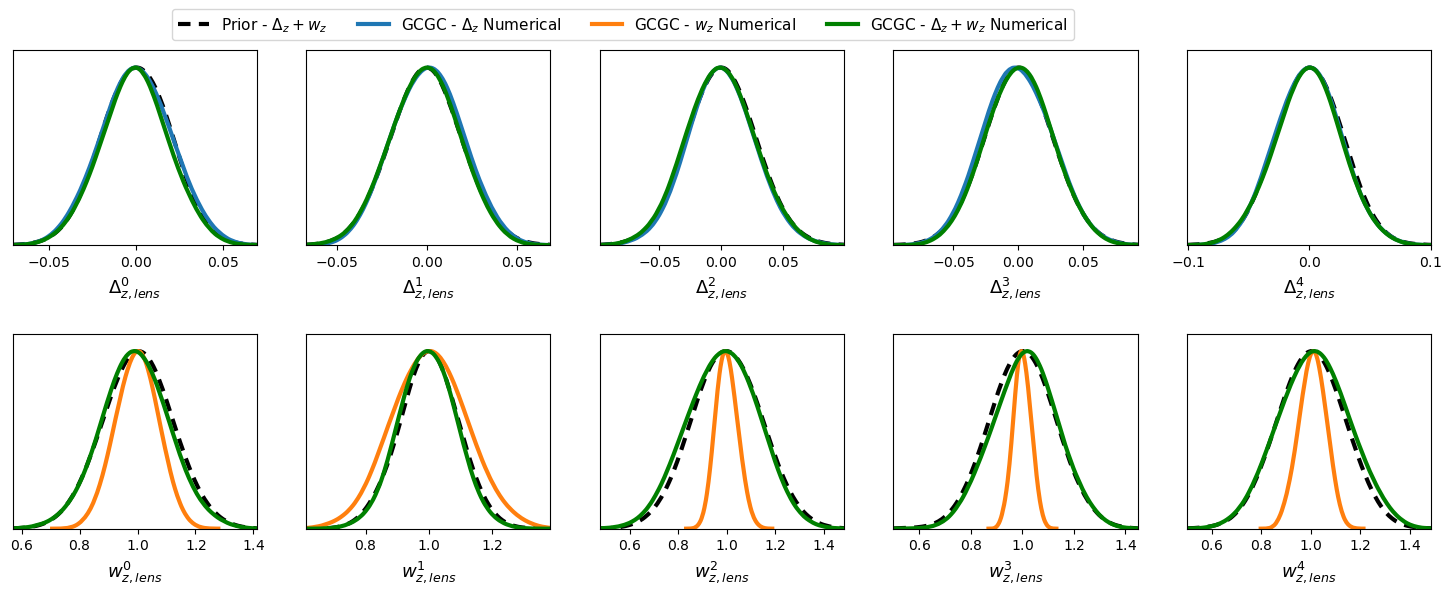

In [38]:
g = plots.get_subplot_plotter(width_inch=15)
g.plots_1d([samples_wzdz_prior,
            samples_gcgc_nuisance_dz_num,
            samples_gcgc_nuisance_wz_num,
            samples_gcgc_nuisance_wzdz_num], 
           ['dz_lens_0', 'dz_lens_1', 'dz_lens_2', 'dz_lens_3', 'dz_lens_4',
            'wz_lens_0', 'wz_lens_1', 'wz_lens_2', 'wz_lens_3', 'wz_lens_4'],
            lws=3, ls=['--', '-', '-'], 
            colors=["black", 'C0', 'C1'],
            nx=5, legend_ncol=4);

g.export("./paper_plots/wzdz.pdf")

## Nzs

In [39]:
import nz_prior as nzp


nz_path = "./data/CosmoDC2/image_gp_bpz_priors/"
nzs = {
"lens_0": np.load(nz_path+"gp_lens_0.npz"),
"lens_1": np.load(nz_path+"gp_lens_1.npz"),
"lens_2": np.load(nz_path+"gp_lens_2.npz"),
"lens_3": np.load(nz_path+"gp_lens_3.npz"),
"lens_4": np.load(nz_path+"gp_lens_4.npz"),
}
gp_nzs = {}
chain = chain_gcgc_nuisance_gp_num
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        W = nz["W"] 
        _, n = W.shape
        param_names = ["alphas_"+tracer_name+"[{}]".format(i) for i in range(1, 5+1)]
        alphas = [chain_gcgc_nuisance_gp_num[param_name].values for param_name in param_names]
        alphas = np.array(alphas).T
        n_samples = alphas.shape[0]
        _nzs = [nz_mean + np.dot(W, alphas[i, :]) for i in range(n_samples)]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        gp_nzs[tracer_name] = _nzs

In [40]:
nz_path = "./data/CosmoDC2/image_PCA_bpz_priors/"
nzs = {
"lens_0": np.load(nz_path+"PCA_lens_0.npz"),
"lens_1": np.load(nz_path+"PCA_lens_1.npz"),
"lens_2": np.load(nz_path+"PCA_lens_2.npz"),
"lens_3": np.load(nz_path+"PCA_lens_3.npz"),
"lens_4": np.load(nz_path+"PCA_lens_4.npz"),
}
pca_nzs = {}
chain = chain_gcgc_nuisance_PCA_num
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        W = nz["W"] 
        _, n = W.shape
        param_names = ["alphas_"+tracer_name+"[{}]".format(i) for i in range(1, 5+1)]
        alphas = [chain[param_name].values for param_name in param_names]
        alphas = np.array(alphas).T
        n_samples = alphas.shape[0]
        _nzs = [nz_mean + np.dot(W, alphas[i, :]) for i in range(n_samples)]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        pca_nzs[tracer_name] = _nzs

In [41]:
SnWs_nzs = {}
dz_path = "./data/CosmoDC2/image_wzdz_bpz_priors/wzdz_prior.npz"
mean_zs = {}
for tracer in list(nzs.keys()):
    mu = np.average(nzs[tracer]["z"], weights=nzs[tracer]["dndz"])
    mean_zs[tracer] = mu
chain = chain_gcgc_nuisance_wzdz_num
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        dzs = chain["dz_lens_{}".format(int(tracer_name[-1]))].values
        wzs = chain["wz_lens_{}".format(int(tracer_name[-1]))].values
        mu = mean_zs[tracer_name]
        n_samples = dz.shape[0]
        _zs = [(z-mu+dzs[i])/wzs[i] + mu for i in range(n_samples)]
        _nzs = [np.interp(_z, z, nz_mean) for _z in _zs]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        SnWs_nzs[tracer_name] = _nzs

In [42]:
wzdz_prior_nzs = {}
dz_path = "./data/CosmoDC2/image_wzdz_bpz_priors/wzdz_prior.npz"
mean_zs = {}
for tracer in list(nzs.keys()):
    mu = np.average(nzs[tracer]["z"], weights=nzs[tracer]["dndz"])
    mean_zs[tracer] = mu
chain = prior_wzdz_chain
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        dzs = chain["dz_lens_{}".format(int(tracer_name[-1]))]
        wzs = chain["wz_lens_{}".format(int(tracer_name[-1]))]
        mu = mean_zs[tracer_name]
        n_samples = dz.shape[0]
        _zs = [(z-mu+dzs[i])/wzs[i] + mu for i in range(n_samples)]
        _nzs = [np.interp(_z, z, nz_mean) for _z in _zs]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        wzdz_prior_nzs[tracer_name] = _nzs

In [43]:
wz_prior_nzs = {}
dz_path = "./data/CosmoDC2/image_wzdz_bpz_priors/wzdz_prior.npz"
mean_zs = {}
for tracer in list(nzs.keys()):
    mu = np.average(nzs[tracer]["z"], weights=nzs[tracer]["dndz"])
    mean_zs[tracer] = mu
chain = prior_wzdz_chain
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        wzs = chain["wz_lens_{}".format(int(tracer_name[-1]))]
        mu = mean_zs[tracer_name]
        n_samples = dz.shape[0]
        _zs = [(z-mu)/wzs[i] + mu for i in range(n_samples)]
        _nzs = [np.interp(_z, z, nz_mean) for _z in _zs]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs]  
        wz_prior_nzs[tracer_name] = _nzs

In [44]:
Ws_nzs = {}
dz_path = "./data/CosmoDC2/image_wzdz_bpz_priors/wzdz_prior.npz"
mean_zs = {}
for tracer in list(nzs.keys()):
    mu = np.average(nzs[tracer]["z"], weights=nzs[tracer]["dndz"])
    mean_zs[tracer] = mu
chain = chain_gcgc_nuisance_wz_num
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        #dzs = chain["dz_lens_{}".format(int(tracer_name[-1]))].values
        wzs = chain["wz_lens_{}".format(int(tracer_name[-1]))].values
        mu = mean_zs[tracer_name]
        n_samples = dz.shape[0]
        #_zs = [(z-mu+dzs[i])/wzs[i] + mu for i in range(n_samples)]
        _zs = [(z-mu)/wzs[i] + mu for i in range(n_samples)]
        _nzs = [np.interp(_z, z, nz_mean) for _z in _zs]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        Ws_nzs[tracer_name] = _nzs

In [45]:
shifts_nzs = {}
shifts_zs = {}
dz_path = "./data/CosmoDC2/image_dz_bpz_priors/dz_prior.npz"
chain = chain_gcgc_nuisance_dz_num
for tracer_name in list(s_gcgc.tracers.keys()):
    if tracer_name not in nzs.keys():
        continue
    else:
        nz = nzs[tracer_name]
        nz_mean = nz["dndz"]
        z = nz["z"]
        dzs = chain["dz_lens_{}".format(int(tracer_name[-1]))].values
        print(tracer_name, "dzs", np.round(np.std(dzs), 4))
        mu = mean_zs[tracer_name]
        n_samples = dz.shape[0]
        _zs = [z + dzs[i] for i in range(n_samples)]
        _nzs = [np.interp(_z, z, nz_mean) for _z in _zs]
        _nzs = [_nz/np.sum(_nz) for _nz in _nzs] 
        shifts_zs[tracer_name] = _zs
        shifts_nzs[tracer_name] = _nzs

lens_0 dzs 0.0186
lens_1 dzs 0.0176
lens_2 dzs 0.0245
lens_3 dzs 0.024
lens_4 dzs 0.0244


In [46]:
path = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/image_nzs_bpz"
data_nzs = {
"lens_0": np.load(path+"/lens_0.npz")["photo_hists"]/np.sum(np.load(path+"/lens_0.npz")["photo_hists"], axis=0),
"lens_1": np.load(path+"/lens_1.npz")["photo_hists"]/np.sum(np.load(path+"/lens_1.npz")["photo_hists"], axis=0),
"lens_2": np.load(path+"/lens_2.npz")["photo_hists"]/np.sum(np.load(path+"/lens_2.npz")["photo_hists"], axis=0),
"lens_3": np.load(path+"/lens_3.npz")["photo_hists"]/np.sum(np.load(path+"/lens_3.npz")["photo_hists"], axis=0),
"lens_4": np.load(path+"/lens_4.npz")["photo_hists"]/np.sum(np.load(path+"/lens_4.npz")["photo_hists"], axis=0),
"source_0": np.load(path+"/shear_0.npz")["photo_hists"]/np.sum(np.load(path+"/shear_0.npz")["photo_hists"], axis=0),
"source_1": np.load(path+"/shear_1.npz")["photo_hists"]/np.sum(np.load(path+"/shear_0.npz")["photo_hists"], axis=0),
"source_2": np.load(path+"/shear_2.npz")["photo_hists"]/np.sum(np.load(path+"/shear_0.npz")["photo_hists"], axis=0),
"source_3": np.load(path+"/shear_3.npz")["photo_hists"]/np.sum(np.load(path+"/shear_0.npz")["photo_hists"], axis=0),
"source_4": np.load(path+"/shear_4.npz")["photo_hists"]/np.sum(np.load(path+"/shear_0.npz")["photo_hists"], axis=0),
}

====
lens_0 dz:  0.0017 wzdz:  0.0022 PCA:  0.0053 GP:  0.0053 Data:  0.0109
====
lens_1 dz:  0.0009 wzdz:  0.0012 PCA:  0.0042 GP:  0.0041 Data:  0.0138
====
lens_2 dz:  0.0018 wzdz:  0.0031 PCA:  0.0037 GP:  0.0036 Data:  0.0108
====
lens_3 dz:  0.0018 wzdz:  0.0021 PCA:  0.0042 GP:  0.0042 Data:  0.0141
====
lens_4 dz:  0.0014 wzdz:  0.0026 PCA:  0.0038 GP:  0.0035 Data:  0.0131


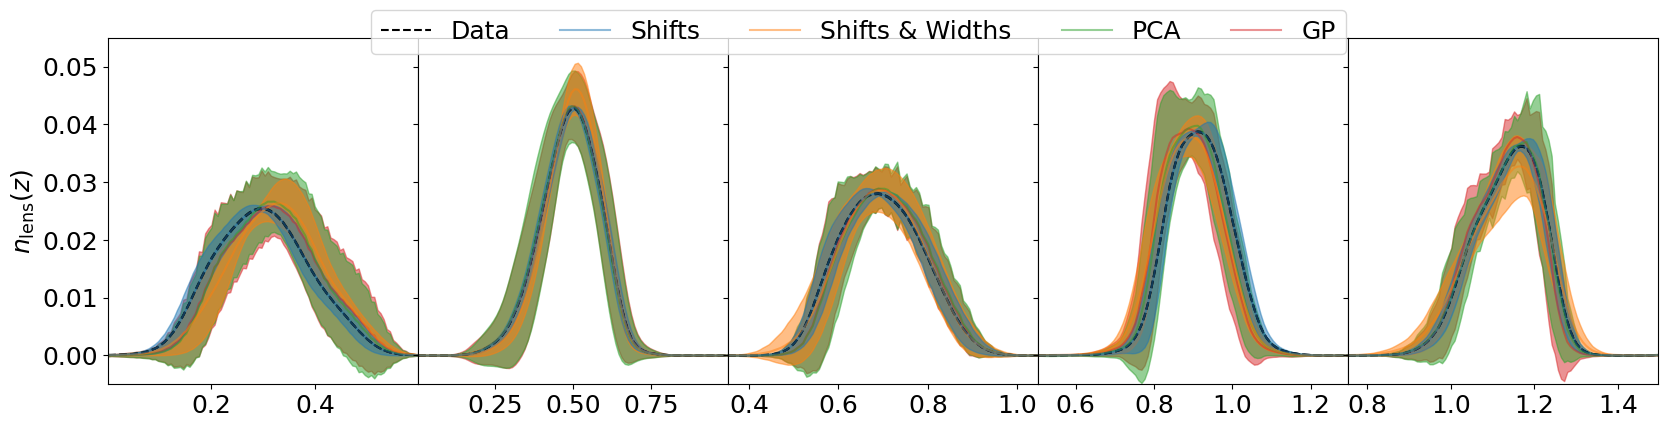

In [47]:
figure, axis = plt.subplots(1, 5, figsize=(5*4,4.5))
figure.subplots_adjust(wspace=0, hspace=0.15)
lens_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, t in enumerate(lens_tracers):
    line0=axis[i].plot(nzs[t]["z"], 
                np.mean(shifts_nzs[t], axis=0)-np.std(data_nzs[t], axis=1), 
                ls="--", color="k")
    axis[i].plot(nzs[t]["z"], 
                np.mean(shifts_nzs[t], axis=0)+np.std(data_nzs[t], axis=1), 
                ls="--", color="k")
    
    line4=axis[i].plot(nzs[t]["z"],
                np.mean(gp_nzs[t], axis=0), 
                alpha=0.5, color="C3",
                label="GP")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(gp_nzs[t], axis=0)-np.std(gp_nzs[t], axis=0), 
                    np.mean(gp_nzs[t], axis=0)+np.std(gp_nzs[t], axis=0), 
                    alpha=0.5, color="C3")
    
    line3=axis[i].plot(nzs[t]["z"],
                np.mean(pca_nzs[t], axis=0), 
                alpha=0.5, color="C2",
                label="PCA")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(pca_nzs[t], axis=0)-np.std(pca_nzs[t], axis=0), 
                    np.mean(pca_nzs[t], axis=0)+np.std(pca_nzs[t], axis=0), 
                    alpha=0.5, color="C2")
    
    line2=axis[i].plot(nzs[t]["z"],
                np.mean(SnWs_nzs[t], axis=0),
                alpha=0.5, color="C1",
                label="Sifts & Widths")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(SnWs_nzs[t], axis=0)-np.std(SnWs_nzs[t], axis=0), 
                    np.mean(SnWs_nzs[t], axis=0)+np.std(SnWs_nzs[t], axis=0), 
                    alpha=0.5, color="C1")
    
    line1=axis[i].plot(nzs[t]["z"],
            np.mean(shifts_nzs[t], axis=0), 
            alpha=0.5, color="C0",
            label="Shifts")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(shifts_nzs[t], axis=0)-np.std(shifts_nzs[t], axis=0), 
                    np.mean(shifts_nzs[t], axis=0)+np.std(shifts_nzs[t], axis=0), 
                    alpha=0.5, color="C0")
    print("====")
    delta_shifts = np.std(shifts_nzs[t], axis=0)
    delta_snws = np.std(SnWs_nzs[t], axis=0)
    delta_pca = np.std(pca_nzs[t], axis=0)
    delta_gp = np.std(gp_nzs[t], axis=0)
    delta_data = np.std(data_nzs[t], axis=0)
    print(t, 
          "dz: ", np.round(np.mean(delta_shifts), 4),
            "wzdz: ", np.round(np.mean(delta_snws), 4),
            "PCA: ", np.round(np.mean(delta_pca), 4),
            "GP: ", np.round(np.mean(delta_gp), 4),
          "Data: ", np.round(np.mean(delta_data), 4))

    axis[i].set_ylim([-0.005, 0.055])
    axis[i].set_xlim([nzs[t]["z"][0], nzs[t]["z"][-1]])
    #axis[0, i].set_xticklabels([])
    if i > 0:
        axis[i].set_yticklabels([])
    else:
        axis[i].set_ylabel(r"$n_{\rm lens}(z)$")

labels = ["Data", "Shifts", "Shifts & Widths", "PCA", "GP"]
lines = [line0[0], line1[0], line2[0], line3[0], line4[0]]
figure.legend(lines, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 0.97))
#figure.savefig("./paper_plots/nz_comparison.pdf", bbox_inches='tight')

====
lens_0 dz:  0.0017 wzdz:  0.0022 PCA:  0.0053 GP:  0.0053 Data:  0.0109
====
lens_1 dz:  0.0009 wzdz:  0.0012 PCA:  0.0042 GP:  0.0041 Data:  0.0138
====
lens_2 dz:  0.0018 wzdz:  0.0031 PCA:  0.0037 GP:  0.0036 Data:  0.0108
====
lens_3 dz:  0.0018 wzdz:  0.0021 PCA:  0.0042 GP:  0.0042 Data:  0.0141
====
lens_4 dz:  0.0014 wzdz:  0.0026 PCA:  0.0038 GP:  0.0035 Data:  0.0131


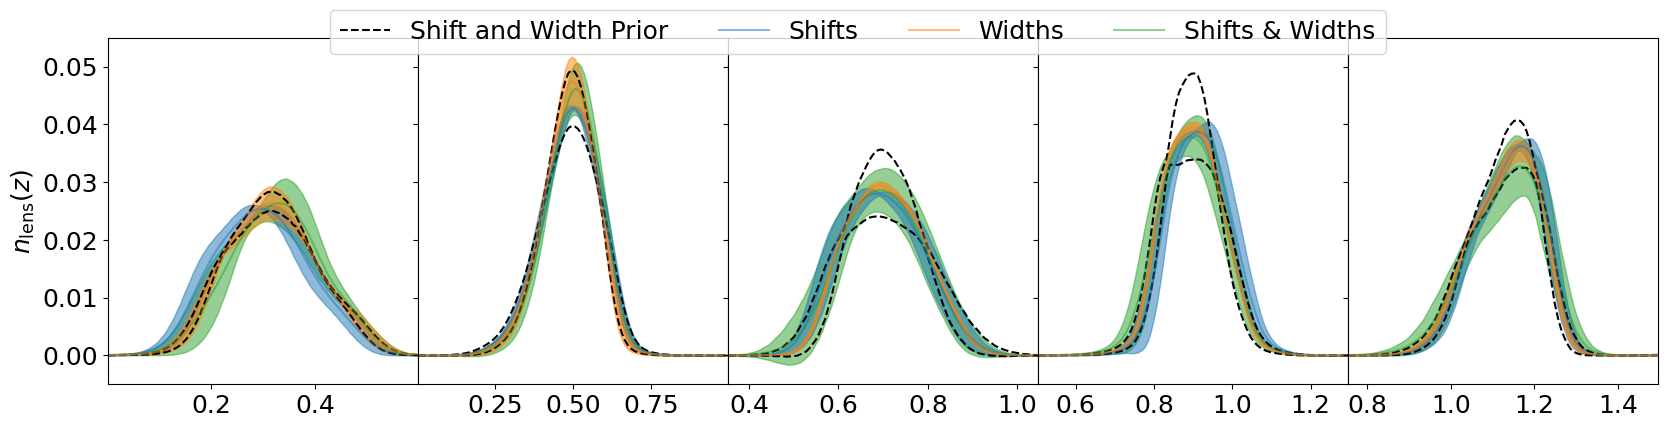

In [48]:
figure, axis = plt.subplots(1, 5, figsize=(5*4,4.5))
figure.subplots_adjust(wspace=0, hspace=0.15)
lens_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
for i, t in enumerate(lens_tracers):
    line0=axis[i].plot(nzs[t]["z"], 
                np.mean(wz_prior_nzs[t], axis=0)-np.std(wz_prior_nzs[t], axis=0), 
                ls="--", color="k")
    axis[i].plot(nzs[t]["z"], 
                np.mean(wz_prior_nzs[t], axis=0)+np.std(wz_prior_nzs[t], axis=0), 
                ls="--", color="k")

    line3=axis[i].plot(nzs[t]["z"],
                np.mean(SnWs_nzs[t], axis=0),
                alpha=0.5, color="C2",
                label="Sifts & Widths")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(SnWs_nzs[t], axis=0)-np.std(SnWs_nzs[t], axis=0), 
                    np.mean(SnWs_nzs[t], axis=0)+np.std(SnWs_nzs[t], axis=0), 
                    alpha=0.5, color="C2")
    
    line1=axis[i].plot(nzs[t]["z"],
            np.mean(shifts_nzs[t], axis=0), 
            alpha=0.5, color="C0",
            label="Shifts")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(shifts_nzs[t], axis=0)-np.std(shifts_nzs[t], axis=0), 
                    np.mean(shifts_nzs[t], axis=0)+np.std(shifts_nzs[t], axis=0), 
                    alpha=0.5, color="C0")
    
    line2=axis[i].plot(nzs[t]["z"],
                np.mean(Ws_nzs[t], axis=0),
                alpha=0.5, color="C1",
                label="Widths")
    axis[i].fill_between(nzs[t]["z"], 
                    np.mean(Ws_nzs[t], axis=0)-np.std(Ws_nzs[t], axis=0), 
                    np.mean(Ws_nzs[t], axis=0)+np.std(Ws_nzs[t], axis=0), 
                    alpha=0.5, color="C1")
    
    print("====")
    delta_shifts = np.std(shifts_nzs[t], axis=0)
    delta_snws = np.std(SnWs_nzs[t], axis=0)
    delta_pca = np.std(pca_nzs[t], axis=0)
    delta_gp = np.std(gp_nzs[t], axis=0)
    delta_data = np.std(data_nzs[t], axis=0)
    print(t, 
          "dz: ", np.round(np.mean(delta_shifts), 4),
            "wzdz: ", np.round(np.mean(delta_snws), 4),
            "PCA: ", np.round(np.mean(delta_pca), 4),
            "GP: ", np.round(np.mean(delta_gp), 4),
          "Data: ", np.round(np.mean(delta_data), 4))

    axis[i].set_ylim([-0.005, 0.055])
    axis[i].set_xlim([nzs[t]["z"][0], nzs[t]["z"][-1]])
    #axis[0, i].set_xticklabels([])
    if i > 0:
        axis[i].set_yticklabels([])
    else:
        axis[i].set_ylabel(r"$n_{\rm lens}(z)$")

labels = ["Shift and Width Prior", "Shifts", "Widths", "Shifts & Widths",]
lines = [line0[0], line1[0], line2[0], line3[0],]
figure.legend(lines, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 0.97))
#figure.savefig("./paper_plots/nz_comparison.pdf", bbox_inches='tight')

## Likelihood

In [49]:
lkl_gcgc_nomarg   = np.transpose(np.transpose(np.array(chain_gcgc_nuisance_nomarg))[13:621])
xi2_gcgc_nomarg  = np.array(chain_gcgc_nuisance_nomarg['lp'])

In [50]:
lkl_gcgc_nomarg_m, lkl_gcgc_nomarg_s   = np.mean(lkl_gcgc_nomarg, axis=1), np.std(lkl_gcgc_nomarg, axis=1)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [51]:
lkl_gcgc_nomarg_cles  = [pacc.ClTheoryEnsemble(cle_gcgc,  np.array(lkl_gcgc_nomarg[i]))  for i in range(len(lkl_gcgc_nomarg))]

In [52]:
sel_gcgc  = np.random.choice(len(lkl_gcgc_nomarg), 10)

In [53]:
cross_pairs =  [['source_0', 'lens_0'],
 ['source_0', 'lens_1'],
 ['source_0', 'lens_2'],
 ['source_0', 'lens_3'],
 ['source_0', 'lens_4'],
 ['source_1', 'lens_0'],
 ['source_1', 'lens_1'],
 ['source_1', 'lens_2'],
 ['source_1', 'lens_3'],
 ['source_1', 'lens_4'],
 ['source_2', 'lens_0'],
 ['source_2', 'lens_1'],
 ['source_2', 'lens_2'],
 ['source_2', 'lens_3'],
 ['source_2', 'lens_4'],
 ['source_3', 'lens_0'],
 ['source_3', 'lens_1'],
 ['source_3', 'lens_2'],
 ['source_3', 'lens_3'],
 ['source_3', 'lens_4'],
 ['source_4', 'lens_0'],
 ['source_4', 'lens_1'],
 ['source_4', 'lens_2'],
 ['source_4', 'lens_3'],
 ['source_4', 'lens_4']]

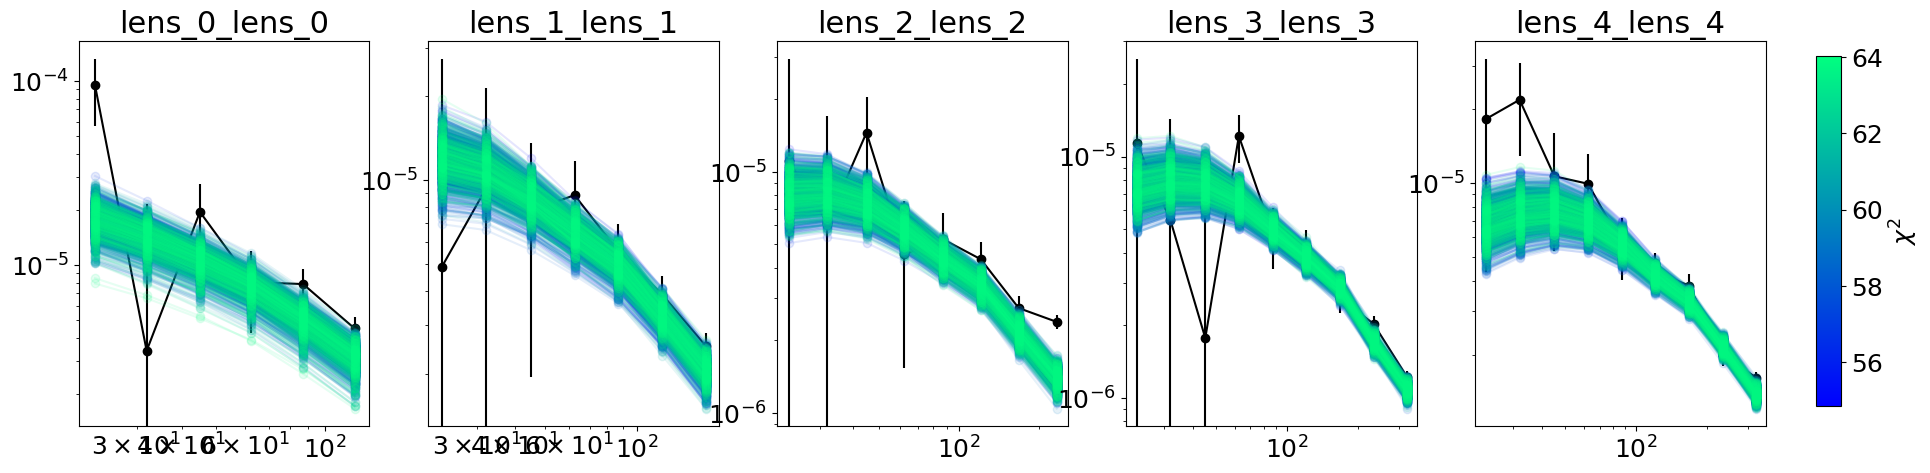

In [54]:
g = pacc.plot_cls([[cle_gcgc], lkl_gcgc_nomarg_cles], cle_gcgc.pairs,
                configs=[
                    {"colors":['black'], "show_legend":False},
                    {"alpha":0.1, "Xi2s":-xi2_gcgc_nomarg[sel_gcgc],
                    "show_legend":False, "show_colobar":True}])
g.savefig("./paper_plots/validation_3x2.pdf", bbox_inches='tight')